# Import Modules & Util Functions

In [5]:
import os
import sys
import glob
import re
import ast
import warnings
import time

import csv
import json
import pickle

import math
import random
import numpy as np
import scipy as sp
import datetime as dt
import pandas as pd
import swifter
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

import portion as P
import itertools as it
import copy
from tqdm.notebook import tqdm
from collections import namedtuple
from pprint import pprint
from pytictoc import TicToc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from myutils import *

# Configure display options
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')

with open(os.path.join(os.getcwd(), "result_save_path.txt"), "r") as f:
    PATH_TO_RESULTS = f.readline()
    
print(PATH_TO_RESULTS)

/home/wmnlab/F/results


# Single Radio Profiling

In [2]:
class Profile():
    def __init__(
        self, filepaths, model_prefix='Test',
        model_id=None, model_dscp=None, save_path='.',
        epoch='1st', dirc_mets='dl_lost',
        scope=None, sp_columns=['type'], ts_column='Timestamp',
        w_size=0.01, sd_factor=3
    ):
        if model_id is None:
            raise TypeError("請輸入模型編號")
        
        self.filepaths = copy.deepcopy(filepaths)
        self.model_name = model_id if model_dscp is None else model_id + '_' + model_dscp
        self.model_prefix = model_prefix
        self.save_path = save_path
        
        self.dirc_mets = dirc_mets
        self.dirc, self.mets = dirc_mets[:2], dirc_mets[-4:]
        self.DIRC_TYPE = 'Downlink' if self.dirc == 'dl' else 'Uplink'
        self.METS_TYPE = 'Packet Loss' if self.mets == 'lost' else 'Excessive Latency'
        self.RATE_TYPE = 'PLR' if self.mets == 'lost' else 'ELR'
        self.sp_columns = sp_columns[:]
        self.ts_column = ts_column
        self.w_size = w_size
        self.sd_factor = sd_factor
        self.epoch = epoch
        
        print(self.save_path, self.model_name, self.model_prefix, self.epoch, self.dirc_mets)
        
        if scope is None:
            self.scope = {
                **{key: (-5.0, 5.0) for key in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II']},
                **{key: (-10.0, 10.0) for key in ['SCGF', 'MCGF', 'NASR']}, 
                'Stable': (-1.0, 1.0)
            }
        else:
            self.scope = copy.deepcopy(scope)
        
        self.Container = { tag: { 'dist_table': [],
                                  'relative_loex_timestamp': [],
                                  'relative_timestamp': [],
                                  'interruption_time': [],
                                  'trigger_loex': [],
                                  'event_count': [] }
                            for tag in self.scope.keys() }
        
        self.Profile = { tag: { 'dist_table': None,
                                'relative_loex_timestamp': [],
                                'relative_timestamp': [],
                                'interruption_time': [],
                                'trigger_loex': [],
                                'event_count': 0 }
                            for tag in self.scope.keys() }
        
        self.scope_models = { stage: copy.deepcopy(self.scope) for stage in ['initial', 'result'] }
        self.hist_models = { tag: None for tag in self.scope.keys() }
        self.kde_models = { tag: (None, None, None) for tag in self.scope.keys() }
        self.plr_models = { tag: 0.0 for tag in self.scope.keys() }
        self.prob_models = { tag: 50.0 for tag in self.scope.keys() }
        
        # Building Model
        self.construct_profile()
        self.modeling()
    
    @staticmethod
    def interpolate(x, y, ratio=0.5):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio
    
    def dist_aggregate(self, tables):
        mets, RATE_TYPE = self.mets, self.RATE_TYPE
        
        table = pd.DataFrame(columns=['window_id', 'tx_count', mets])
        table[mets] = table[mets].astype('Int32')
        table['window_id'] = table['window_id'].astype('float32')
        table['tx_count'] = table['tx_count'].astype('Int32')
        
        tables = [t for t in tables if t is not None]
        for this_table in tables:
            table = table.merge(this_table, on=['window_id'], how='outer').fillna(0)
            table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
            table[mets] = table[f'{mets}_x'] + table[f'{mets}_y']
            table = table[['window_id','tx_count',mets]]
        
        table[RATE_TYPE] = table[mets] / (table['tx_count'] + 1e-9) * 100
        table[RATE_TYPE] = table[RATE_TYPE].astype('float32')
        
        table = table[['window_id', 'tx_count', mets, RATE_TYPE]].sort_values(by=['window_id']).reset_index(drop=True)
        return table
    
    @staticmethod
    def downsample(data, sample_size=100000):
        return mean_downsample(data, sample_size=sample_size)
    
    @staticmethod
    def total_area_histogram_with_centers(x_centers, heights, bin_width):
        # 計算每個 bin 的面積並相加
        total_area = bin_width * sum(heights)
        return total_area
    
    @staticmethod
    def total_area_kde(kde, lower_bound=-np.inf, upper_bound=np.inf):
        # 定義積分函數
        def integrand(x):
            return kde(x)
        total_area, _ = quad(integrand, lower_bound, upper_bound)
        return total_area


    def create_instance(self, df, center, interval):
        mets, w_size = self.mets, self.w_size
        df = df[(df[self.ts_column] >= interval.lower) & (df[self.ts_column] < interval.upper)].copy().reset_index(drop=True)
        
        # Relative window converted from timestamp
        df['relative_time'] = (df['Timestamp'] - center).dt.total_seconds()
        df['window_id'] = ((df['relative_time'] + w_size / 2) // w_size) * w_size  # 四捨五入
        
        if mets == 'lost':
            loex_df = df[df['lost']].copy()
            ts_group = df.groupby(['window_id'])
            table = ts_group.agg({'lost': ['count', 'sum'], 'Timestamp': ['first']}).reset_index()
        else:
            df['excl_exact'] = ~df['lost'] & df['excl']
            loex_df = df[df['excl_exact']].copy()
            ts_group = df.groupby(['window_id'])
            table = ts_group.agg({'excl_exact': ['count','sum'], 'Timestamp': ['first']}).reset_index()
        
        table.columns = ['window_id', 'tx_count', mets, 'Timestamp']
        
        return table, loex_df['relative_time'].to_list(), df['relative_time'].to_list()
    
    
    def setup_profile(self, df, ho_df):
        scope, mets = self.scope, self.mets
        
        # Initialize "Register"
        Register = { tag: { 'dist_table': [],
                            'relative_loex_timestamp': [],
                            'relative_timestamp': [],
                            'interruption_time': [],
                            'trigger_loex': [] }
                    for tag in scope.keys() }
        this_df = df.copy()
        
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip it!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, Profile.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, Profile.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, Profile.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, Profile.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)

            # Consider the stable duration before an event starts
            stable_df = this_df[this_df[self.ts_column] < interval.lower].copy()
            stable_df['Timestamp_to_second'] = stable_df['Timestamp'].dt.floor('S')
            
            if not stable_df.empty:
                unique_timestamps = stable_df['Timestamp_to_second'].unique()
                
                tmp_df = stable_df.copy()
                for ts in unique_timestamps:
                    stable_center = ts + pd.Timedelta(seconds=0.5)
                    stable_interval = P.closed(ts, min(ts + pd.Timedelta(seconds=1), interval.lower))
                    
                    # Create an instance of stable profile
                    dist_table, relative_loex_timestamp, relative_timestamp = self.create_instance(tmp_df.copy(), stable_center, stable_interval)
                    
                    # Feed into "Register"
                    if len(relative_loex_timestamp):
                        Register['Stable']['trigger_loex'].append(1)
                        Register['Stable']['dist_table'].append(dist_table)
                        Register['Stable']['relative_loex_timestamp'] += relative_loex_timestamp
                    else:
                        Register['Stable']['trigger_loex'].append(0)
                    Register['Stable']['interruption_time'].append((stable_interval.upper - stable_interval.lower).total_seconds())
                    Register['Stable']['relative_timestamp'] += relative_timestamp
                    
                    # Update dataframe to accelerate
                    tmp_df = tmp_df[tmp_df[self.ts_column] >= ts + pd.Timedelta(seconds=1)]
            
            # Create an instance of handover profile
            dist_table, relative_loex_timestamp, relative_timestamp = self.create_instance(this_df.copy(), start_ts, interval)
            
            # Feed into "Register"
            if len(relative_loex_timestamp):
                Register[tag]['trigger_loex'].append(1)
                Register[tag]['dist_table'].append(dist_table)
                Register[tag]['relative_loex_timestamp'] += relative_loex_timestamp
            else:
                Register[tag]['trigger_loex'].append(0)
            Register[tag]['interruption_time'].append(interruption_time)
            Register[tag]['relative_timestamp'] += relative_timestamp
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()

        # Consider the stable duration after the last event ends
        stable_df = this_df.copy()
        stable_df['Timestamp_to_second'] = stable_df['Timestamp'].dt.floor('S')

        if not stable_df.empty:
            unique_timestamps = stable_df['Timestamp_to_second'].unique()
            
            tmp_df = stable_df.copy()
            for ts in unique_timestamps:
                stable_center = ts + pd.Timedelta(seconds=0.5)
                stable_interval = P.closed(ts, ts + pd.Timedelta(seconds=1))
                
                # Create an instance of stable profile
                dist_table, relative_loex_timestamp, relative_timestamp = self.create_instance(tmp_df.copy(), stable_center, stable_interval)
                
                # Feed into "Register"
                if len(relative_loex_timestamp):
                    Register['Stable']['trigger_loex'].append(1)
                    Register['Stable']['dist_table'].append(dist_table)
                    Register['Stable']['relative_loex_timestamp'] += relative_loex_timestamp
                else:
                    Register['Stable']['trigger_loex'].append(0)
                Register['Stable']['interruption_time'].append((stable_interval.upper - stable_interval.lower).total_seconds())
                Register['Stable']['relative_timestamp'] += relative_timestamp
                
                # Update dataframe to accelerate
                tmp_df = tmp_df[tmp_df[self.ts_column] >= ts + pd.Timedelta(seconds=1)]
        
        return Register
    
    
    def construct_profile(self):
        scope, dirc, mets = self.scope, self.dirc, self.mets
        n = len(self.filepaths)
        for i, filepath in enumerate(self.filepaths):
            
            # if i > 0:
            #     break
            
            path = filepath[1] if dirc == 'dl' else filepath[2]
            print(f'{i+1}/{n}', filepath[0]); print(f'{i+1}/{n}', path)
            
            if os.path.isfile(filepath[0]):
                ho_df = generate_dataframe(filepath[0], parse_dates=['start', 'end'])
            else:
                print('{} does not exist!!!'.format(filepath[0]))
                print('makefile:', filepath[0])
                ho_df, _ = mi_parse_handover(generate_dataframe(filepath[3], parse_dates=['Timestamp']))
                ho_df.to_csv(filepath[0], index=False)
            
            if ho_df.empty:
                print('*************** EMPTY HO INFO ***************')
                continue
            
            if dirc == 'dl':
                df = generate_dataframe(filepath[1], parse_dates=['Timestamp'], usecols=['seq', 'Timestamp', 'lost', 'excl', 'latency'])
            else:
                df = generate_dataframe(filepath[2], parse_dates=['Timestamp'], usecols=['seq', 'Timestamp', 'lost', 'excl', 'latency'])
                
            df, ho_df, empty_data = data_aligner(df, ho_df)
            
            if empty_data:
                print('*************** EMPTY DATA ***************')
                continue
                
            Register = self.setup_profile(df, ho_df)
            
            # Append "Register" for each trace
            for tag in scope.keys():
                table = self.dist_aggregate(Register[tag]['dist_table'])
                self.Container[tag]['dist_table'].append(table)
                self.Container[tag]['relative_loex_timestamp'].append(Register[tag]['relative_loex_timestamp'])
                self.Container[tag]['relative_timestamp'].append(Register[tag]['relative_timestamp'])
                self.Container[tag]['trigger_loex'].append(Register[tag]['trigger_loex'])
                self.Container[tag]['interruption_time'].append(Register[tag]['interruption_time'])
                self.Container[tag]['event_count'].append(len(Register[tag]['interruption_time']))
            
        for tag in scope.keys():
            self.Profile[tag]['dist_table'] = self.dist_aggregate(self.Container[tag]['dist_table'])
            self.Container[tag]['dist_table'] = []
            
            data = []
            for lst in self.Container[tag]['relative_loex_timestamp']:
                data += lst
            self.Profile[tag]['relative_loex_timestamp'] = Profile.downsample(data)
            self.Container[tag]['relative_loex_timestamp'] = []
            
            data = []
            for lst in self.Container[tag]['relative_timestamp']:
                data += lst
            self.Profile[tag]['relative_timestamp'] = Profile.downsample(data)
            self.Container[tag]['relative_timestamp'] = []
            
            del data
            
            for lst in self.Container[tag]['trigger_loex']:
                self.Profile[tag]['trigger_loex'] += lst
            self.Container[tag]['trigger_loex'] = []
            
            for lst in self.Container[tag]['interruption_time']:
                self.Profile[tag]['interruption_time'] += lst
            self.Container[tag]['interruption_time'] = []
            
            self.Profile[tag]['event_count'] += sum(self.Container[tag]['event_count'])
            self.Container[tag]['event_count'] = []
    
    
    def modeling(self):
        scope, sd_factor, w_size = self.scope, self.sd_factor, self.w_size
        dirc, mets, RATE_TYPE = self.dirc, self.mets, self.RATE_TYPE
        
        for tag in scope.keys():
            # print('===============================================================')
            # print(tag, self.dirc_mets)
            
            left_bound, right_bound = scope[tag]
            table = self.Profile[tag]['dist_table']
            loex_data = self.Profile[tag]['relative_loex_timestamp']
            xmit_data = self.Profile[tag]['relative_timestamp']
            trigger_lst = self.Profile[tag]['trigger_loex']
            
            self.hist_models[tag] = table.copy()
            
            if len(trigger_lst) == 0:
                continue
            
            estimated_p = sum(trigger_lst) / len(trigger_lst)
            self.prob_models[tag] = estimated_p
            
            PLR = sum(table[mets]) / (sum(table['tx_count']) + 1e-9) * 100
            self.plr_models[tag] = PLR
            
            # if loex_data == 1, then kde function bumps error: 
            # ValueError: `dataset` input should have multiple elements.
            if len(loex_data) < 2:
                continue
            
            if self.epoch == 'last':
                left_bound, right_bound = scope[tag]
            else:
                if tag == 'Stable':
                    mean = 0
                    left_bound, right_bound = -0.5, 0.5
                else:
                    loex_table = table[table[mets] > 0].reset_index(drop=True)
                    mean, stdev = np.mean(loex_data), np.std(loex_data)
                    left_bound = math.floor(max(left_bound, mean - sd_factor * stdev, loex_table.iloc[0]['window_id']) * 10) / 10
                    right_bound = math.ceil(min(right_bound, mean + sd_factor * stdev, loex_table.iloc[-1]['window_id']) * 10) / 10
                
                self.scope_models['result'][tag] = (left_bound, right_bound)
            
            x = np.asarray(table['window_id'], dtype=np.float64)
            y = np.asarray(table[RATE_TYPE], dtype=np.float64)
            
            # 計算直方圖的面積
            hist_area = Profile.total_area_histogram_with_centers(x, y, w_size)
            # print("Total area of histogram:", hist_area)
            
            kde1 = gaussian_kde(loex_data)
            kde2 = gaussian_kde(xmit_data)
            def kde(x):
                kde2_values = kde2(x)
                # 檢查 kde2 是否為零，如果是則返回一個超大值，把 loss rate 壓成 0
                kde2_values[kde2_values == 0] = 1e9
                return kde1(x) / kde2_values
            
            # 計算 KDE 下的總面積（只計算正負3個標準差內的點，理論上 scalar 會稍微高估，但不會太多）
            kde_area = Profile.total_area_kde(kde, left_bound, right_bound)
            # print("Total area under KDE:", kde_area)
            
            scalar = hist_area / kde_area
            # print("Scalar:", scalar)
            
            self.kde_models[tag] = (scalar, kde1, kde2)
    
    
    def plot(self, sd_factor=3):
        scope, dirc, mets = self.scope, self.dirc, self.mets
        METS_TYPE, RATE_TYPE, DIRC_TYPE = self.METS_TYPE, self.RATE_TYPE, self.DIRC_TYPE
        
        for tag in scope.keys():
            loex_data = self.Profile[tag]['relative_loex_timestamp']
            xmit_data = self.Profile[tag]['relative_timestamp']
            
            left_bound, right_bound = self.scope_models['result'][tag]
            table = self.hist_models[tag]
            scalar, kde1, kde2 = self.kde_models[tag]
            
            if len(loex_data) == 0:
                continue
            
            fig, ax = plt.subplots(figsize=(6, 4))
            
            x = np.asarray(table['window_id'], dtype=np.float64)
            y1 = np.asarray(table['tx_count'], dtype=np.float64)
            y2 = np.asarray(table[RATE_TYPE], dtype=np.float64)
            
            ax_twin = ax.twinx()
            ax_twin.bar(x, y1, label='tx_packet', color='tab:blue', width=0.01, alpha=0.15)
            ax.bar(x, y2, label='loss_rate', color='tab:blue', width=0.01, alpha=0.97)
            
            if kde1 is not None and kde2 is not None:
                x = np.linspace(min(xmit_data), max(xmit_data), 1000)
                
                def kde(x):
                    kde2_values = kde2(x)
                    # 檢查 kde2 是否為零，如果是則返回一個超大值，把 loss/excl rate 壓成 0
                    kde2_values[kde2_values == 0] = 1e9
                    return kde1(x) / kde2_values
            
                density = scalar * kde(x)
                ax.fill_between(x, density, label='KDE', color='tab:orange', alpha=0.45, linewidth=0)
    
            # find the scope and boundaries
            ax.axvline(x=0, color='red', linestyle='-', alpha=0.5)
            ax.axvline(x=left_bound, color='blue', linestyle='--', label=f'-{sd_factor} Std')
            ax.axvline(x=right_bound, color='blue', linestyle='--', label=f'+{sd_factor} Std')
            
            bottom, top = ax.get_ylim()
            ax.text(left_bound, bottom-0.05*(top-bottom), '{:.1f}'.format(left_bound), ha='center', fontweight='bold', fontsize=10, color='blue')
            ax.text(right_bound, bottom-0.05*(top-bottom), '{:.1f}'.format(right_bound), ha='center', fontweight='bold', fontsize=10, color='blue')
            
            left, right = ax.get_xlim()
            count = self.Profile[tag]['event_count']
            intr = round(np.mean(self.Profile[tag]['interruption_time']), 3)
            trigger = sum(self.Profile[tag]['trigger_loex'])
            trigger_rate = round(self.prob_models[tag] * 100, 1)
            LossR = round(sum(table[mets]) / (sum(table['tx_count']) + 1e-9) * 100, 2)
            ax.text(left+0.06*(right-left), bottom+0.73*(top-bottom), f'Event Count: {count}\nTrigger Loss: {trigger} ({trigger_rate}%)\nAvg {RATE_TYPE}: {LossR}%\nAvg INTR: {intr} (sec)', ha='left', fontweight='bold', fontsize=10)
            
            ax.set_title(f'{DIRC_TYPE} {RATE_TYPE}: {tag}')
            ax.set_ylabel(f'{METS_TYPE} Rate (%)')
            ax.set_xlabel('Relative Timestamp (sec)')
            
            ax_twin.set_ylabel('Number of Packets Transmit')
            
            # 合併兩個圖的legend
            lines, labels = ax.get_legend_handles_labels()
            lines2, labels2 = ax_twin.get_legend_handles_labels()
            # ax.legend(lines + lines2, labels + labels2, loc='best')
            ax.legend(lines + lines2, labels + labels2, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=5)
            
            save_path = os.path.join(self.save_path, self.model_name, self.dirc_mets, 'models', 'plot')
            if not os.path.isdir(save_path):
                os.makedirs(save_path)
            
            if self.epoch == 'last':
                save_path = os.path.join(save_path, f'{self.model_prefix}_{tag}.png')
            else:
                save_path = os.path.join(save_path, f'{self.model_prefix}_{tag}_{self.epoch}.png')
            
            print(save_path)
            
            fig.savefig(save_path, dpi=300)
            plt.gcf().autofmt_xdate()
            plt.show()
    
    
    def save_models(self):
        save_path = os.path.join(self.save_path, self.model_name, self.dirc_mets, 'models')
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        
        if self.epoch == 'last':
            print('Save models:', self.model_prefix, '->', save_path)
            save_path = os.path.join(save_path, self.model_prefix)
        else:
            print('Save models:', f'{self.model_prefix}_{self.epoch}', '->', save_path)
            save_path = os.path.join(save_path, f'{self.model_prefix}_{self.epoch}')
            
        print()
        
        with open(f'{save_path}_kde_models.pkl', 'wb') as f:
            pickle.dump(self.kde_models, f)
        with open(f'{save_path}_hist_models.pkl', 'wb') as f:
            pickle.dump(self.hist_models, f, protocol=pickle.HIGHEST_PROTOCOL)
        with open(f'{save_path}_scope_models.pkl', 'wb') as f:
            pickle.dump(self.scope_models, f)
        with open(f'{save_path}_plr_models.pkl', 'wb') as f:
            pickle.dump(self.plr_models, f)
        with open(f'{save_path}_sr_prob_models.pkl', 'wb') as f:
            pickle.dump(self.prob_models, f)

# Generate Model ID

In [3]:
model_id = model_identity()
model_dscp = 'test'
print(model_id, model_dscp)

20240403_01430006f4 test


# BR Models

In [4]:
# Single Radio Example
# dates = data_loader(query_dates=True, show_info=True)

# selected_dates = [s for s in dates if s >= '2023-09-12']
selected_dates = ['2024-03-19']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['BR']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

print(len(filepaths))
# pprint(filepaths)

18


. 20240403_01430006f4_test BR 1st dl_lost
1/18 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/handover_info_log.csv
1/18 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_dnlk_loss_latency.csv
./20240403_01430006f4_test/dl_lost/models/plot/BR_MCGH_1st.png


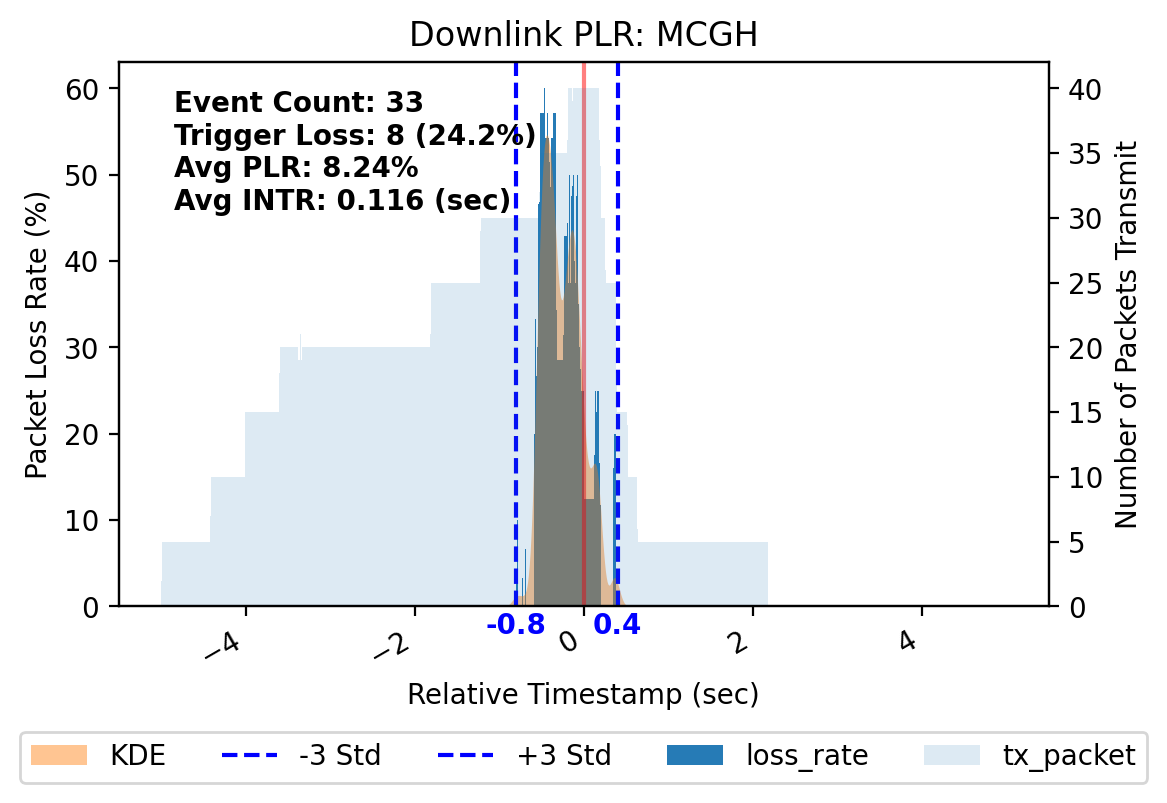

./20240403_01430006f4_test/dl_lost/models/plot/BR_MNBH_1st.png


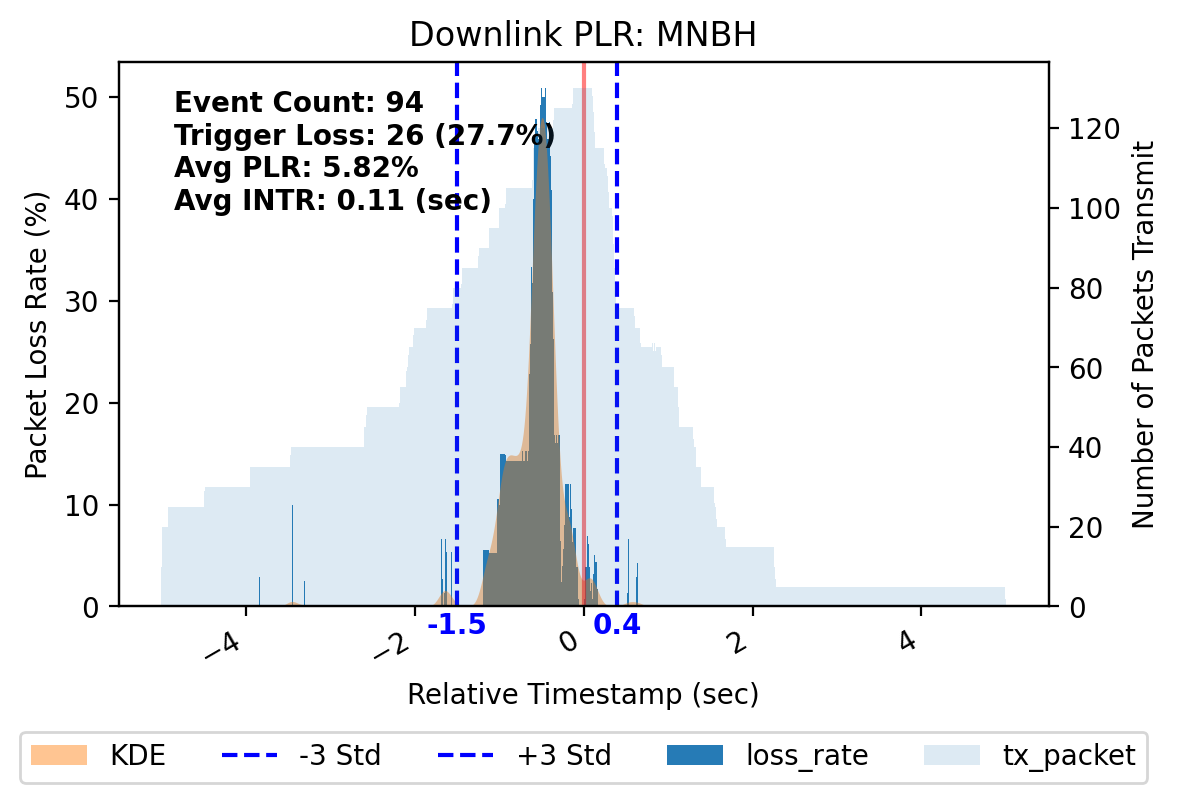

./20240403_01430006f4_test/dl_lost/models/plot/BR_SCGM_1st.png


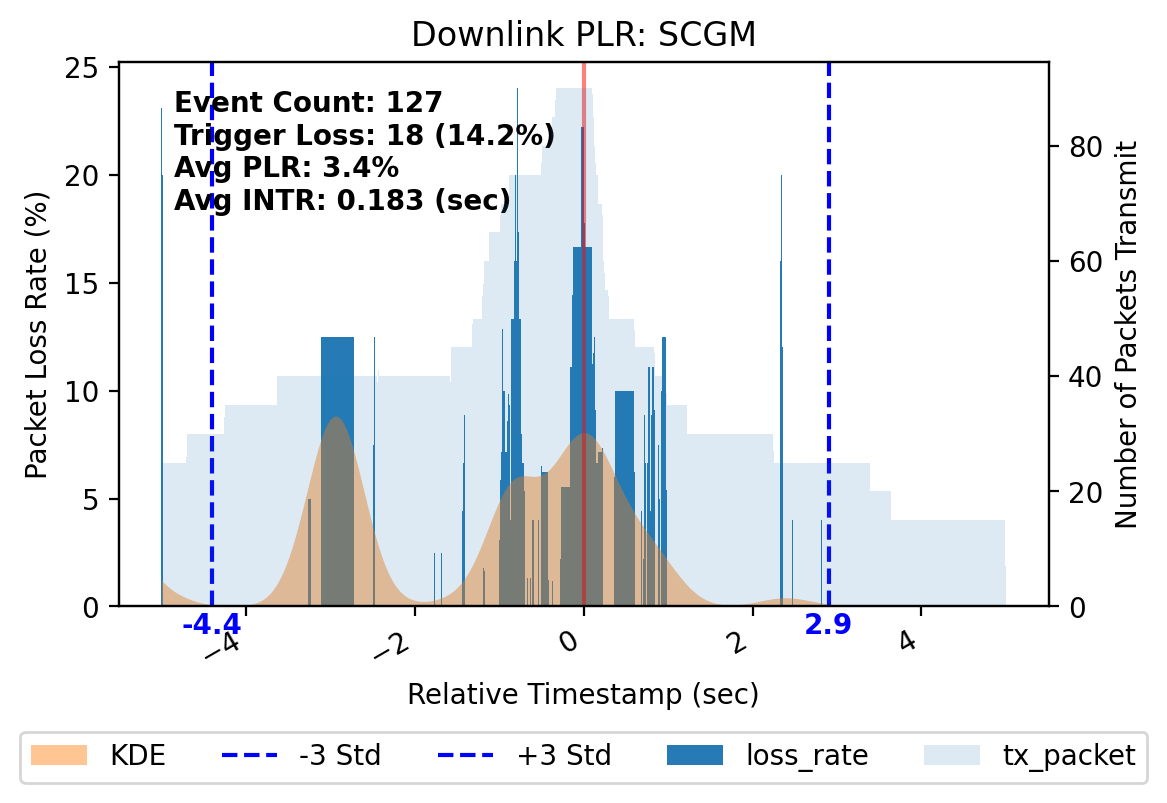

./20240403_01430006f4_test/dl_lost/models/plot/BR_SCGR-II_1st.png


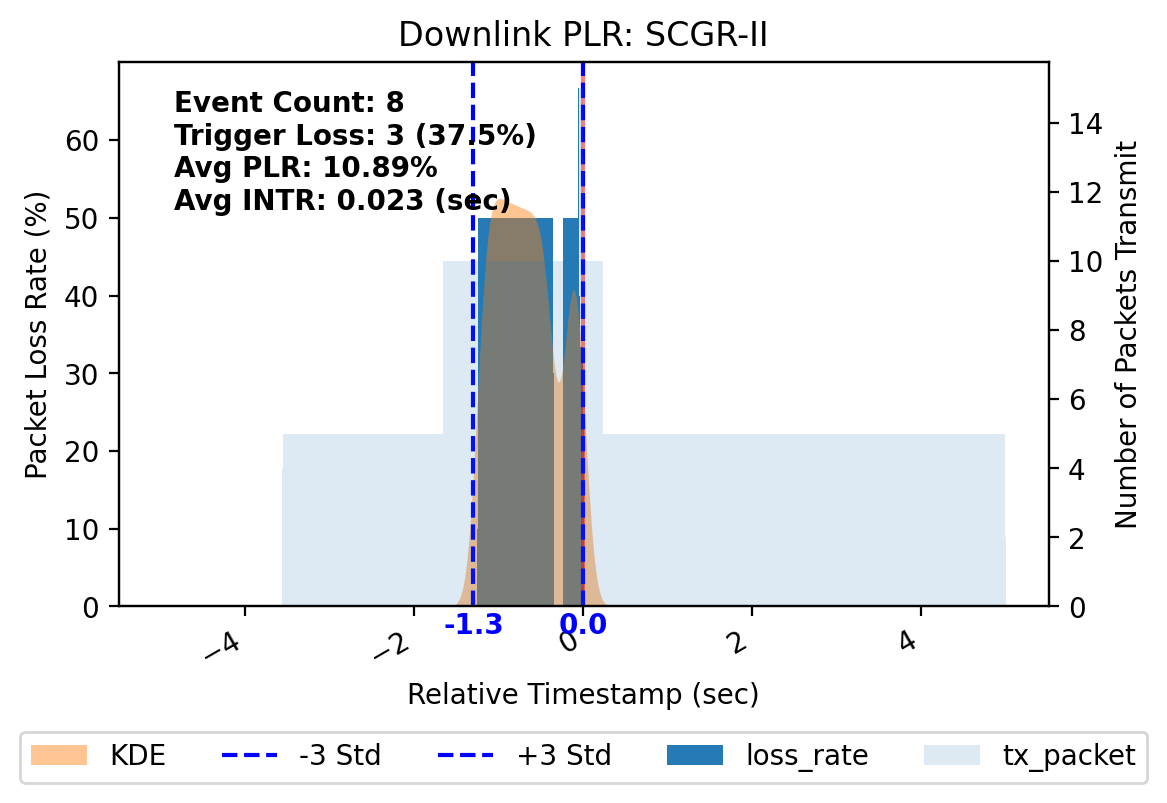

./20240403_01430006f4_test/dl_lost/models/plot/BR_SCGC-I_1st.png


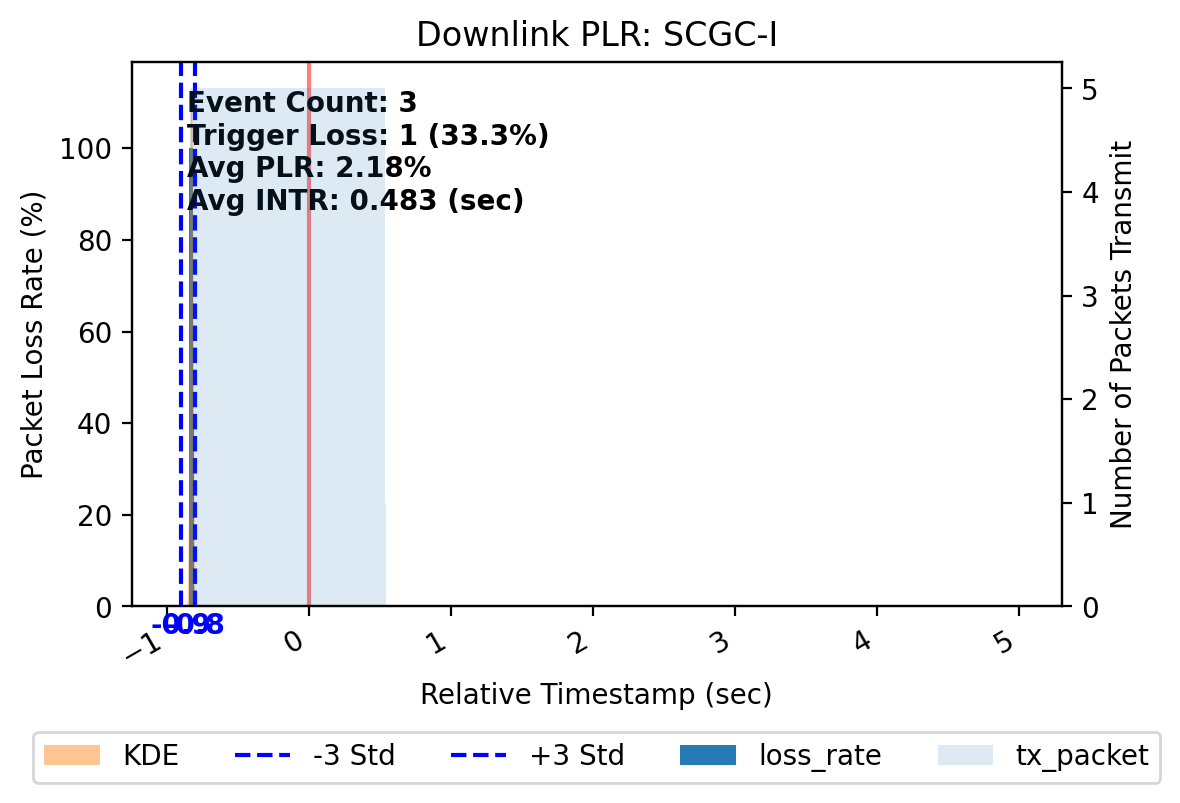

./20240403_01430006f4_test/dl_lost/models/plot/BR_SCGC-II_1st.png


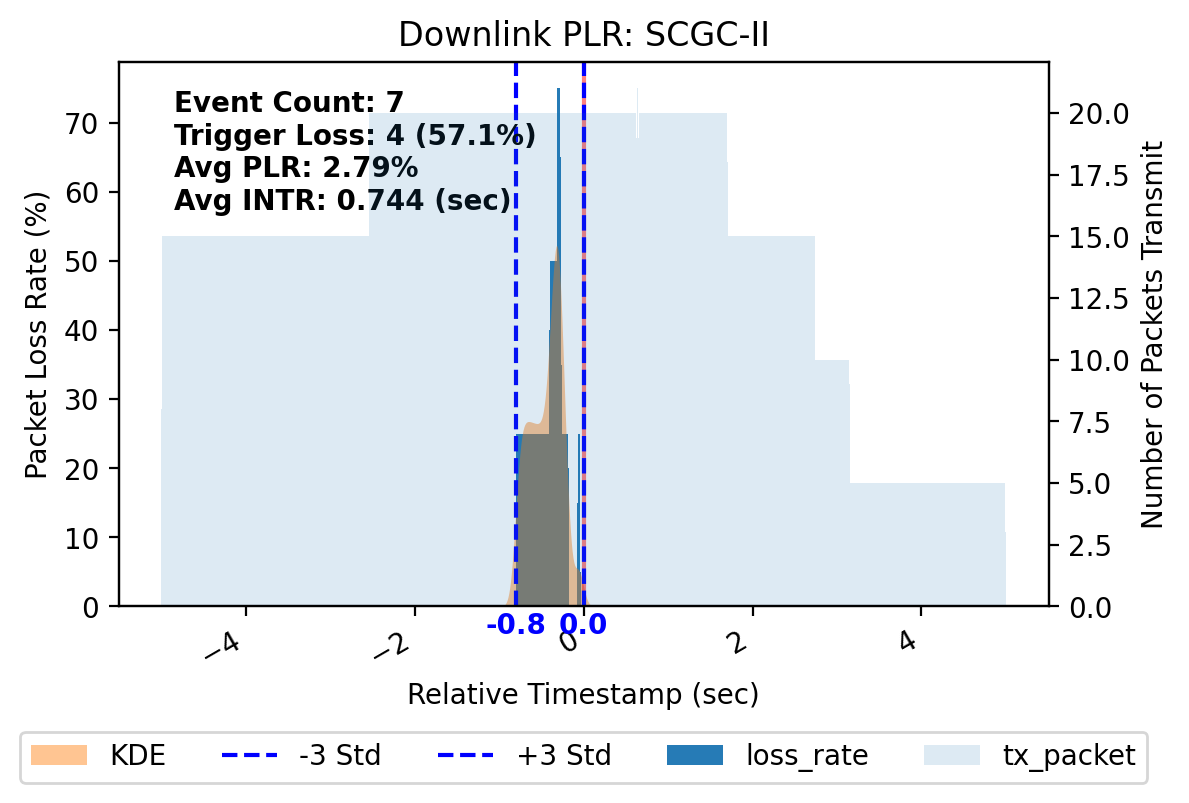

./20240403_01430006f4_test/dl_lost/models/plot/BR_SCGF_1st.png


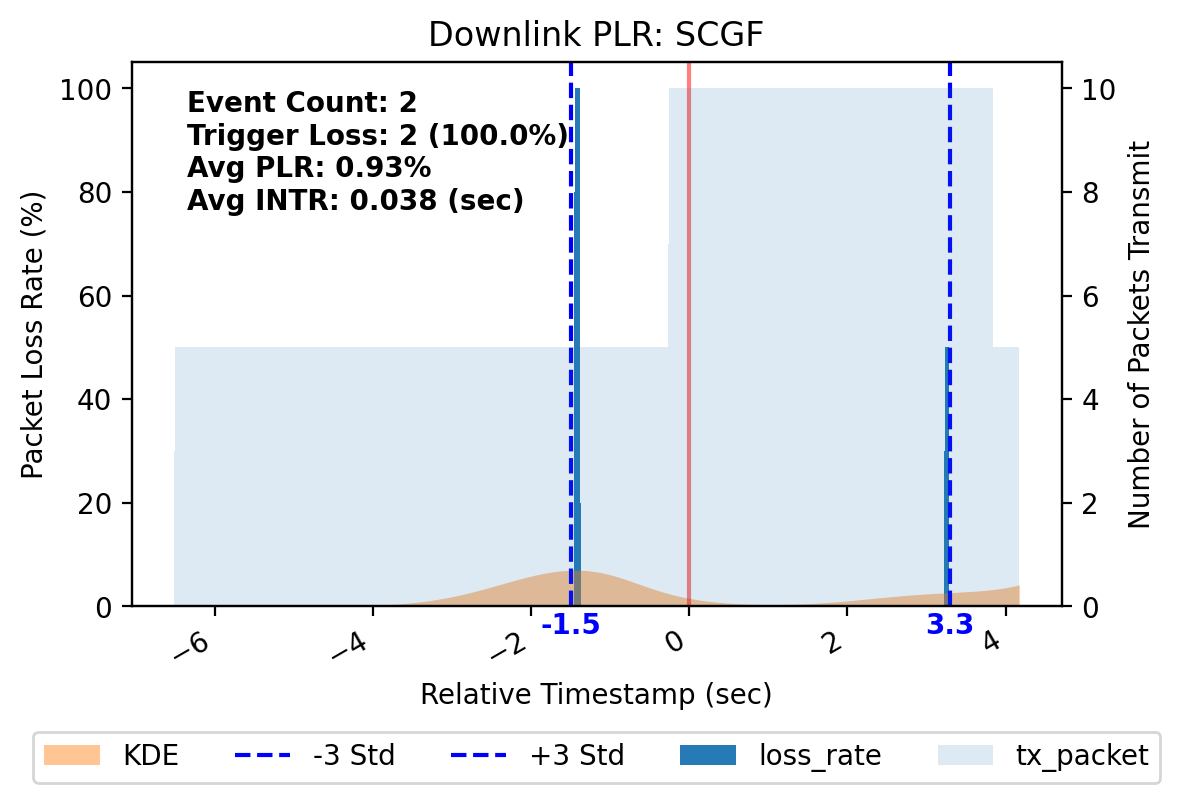

./20240403_01430006f4_test/dl_lost/models/plot/BR_MCGF_1st.png


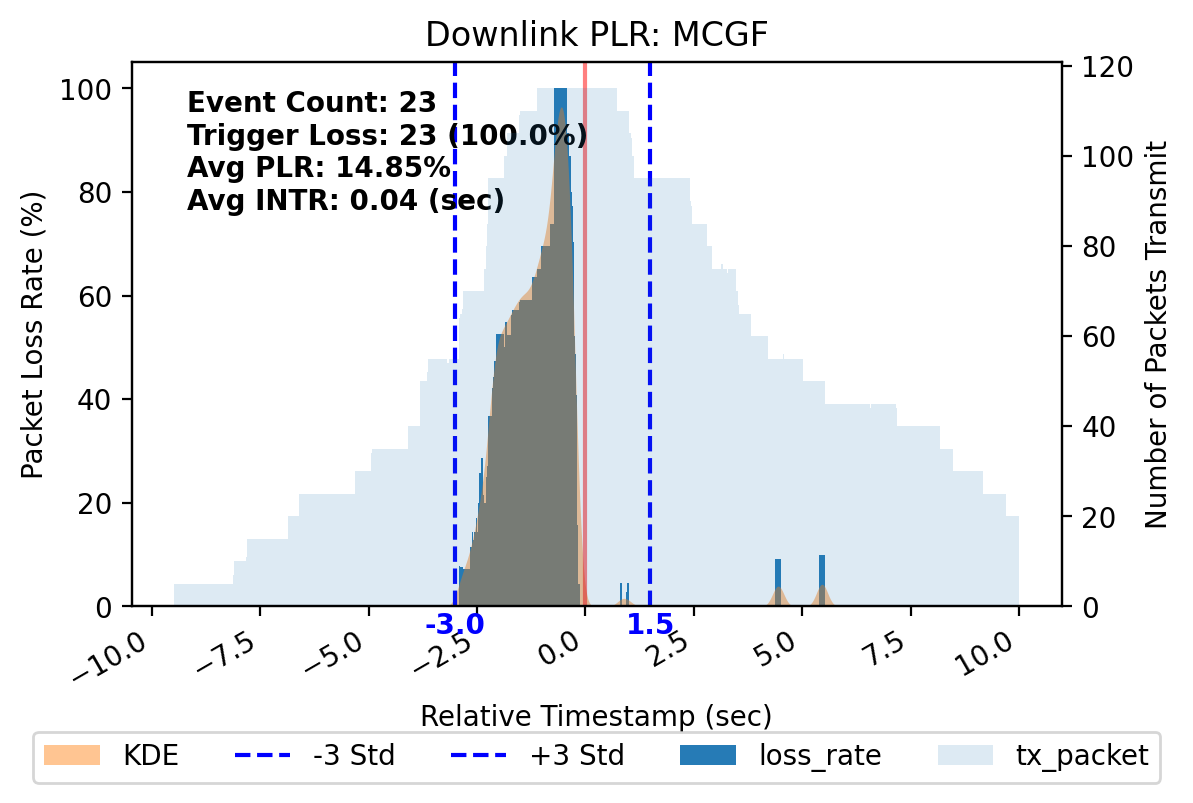

./20240403_01430006f4_test/dl_lost/models/plot/BR_Stable_1st.png


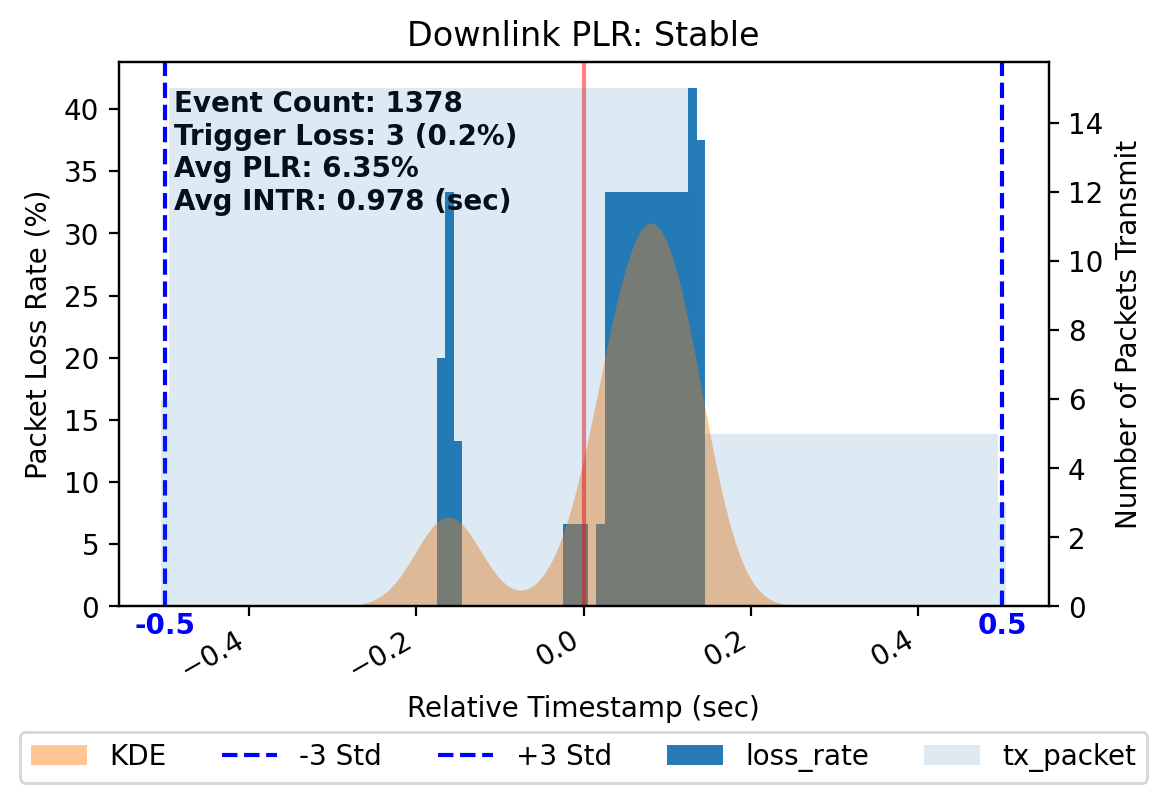

. 20240403_01430006f4_test BR last dl_lost
1/18 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/handover_info_log.csv
1/18 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_dnlk_loss_latency.csv
./20240403_01430006f4_test/dl_lost/models/plot/BR_MCGH.png


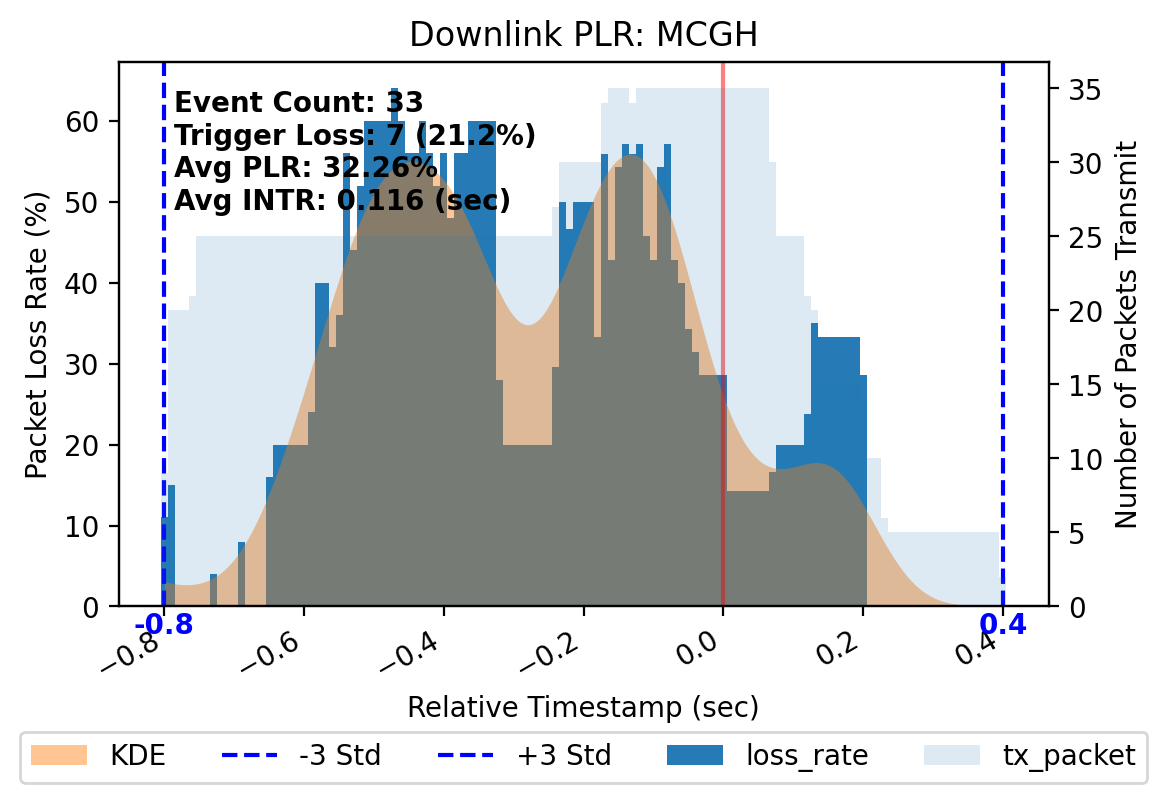

./20240403_01430006f4_test/dl_lost/models/plot/BR_MNBH.png


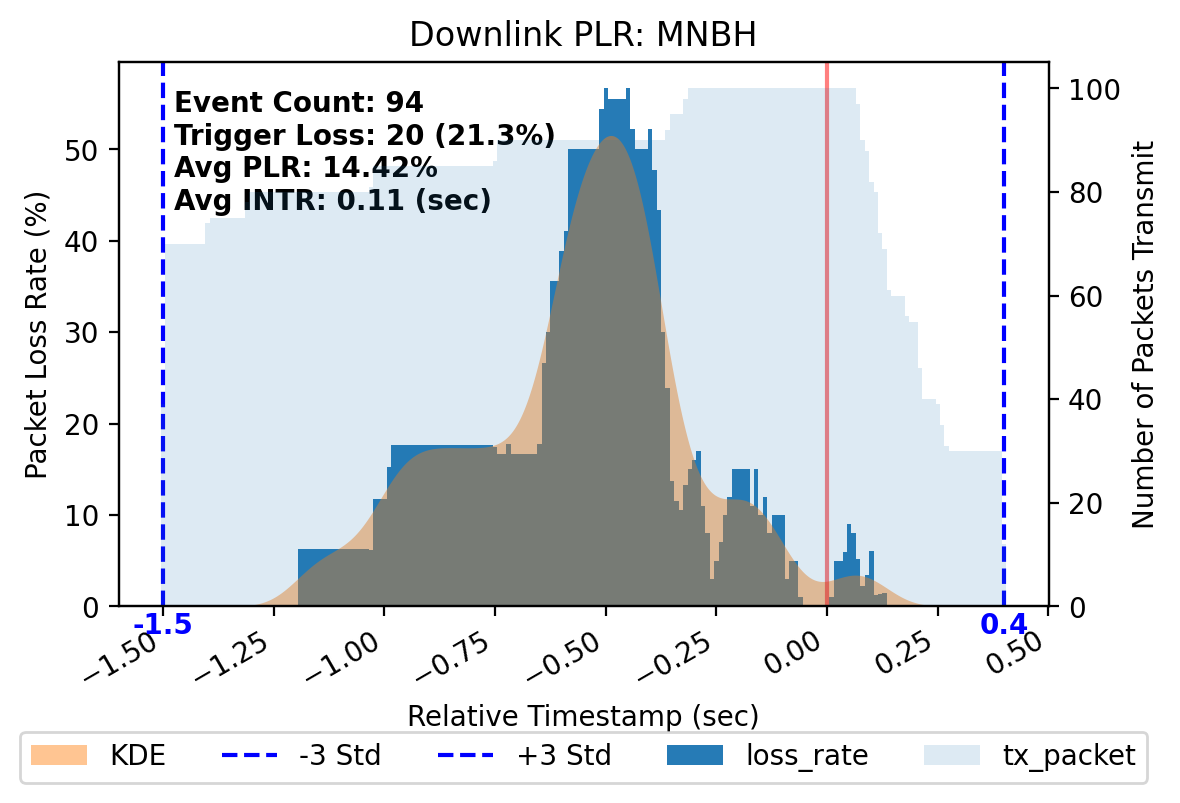

./20240403_01430006f4_test/dl_lost/models/plot/BR_SCGM.png


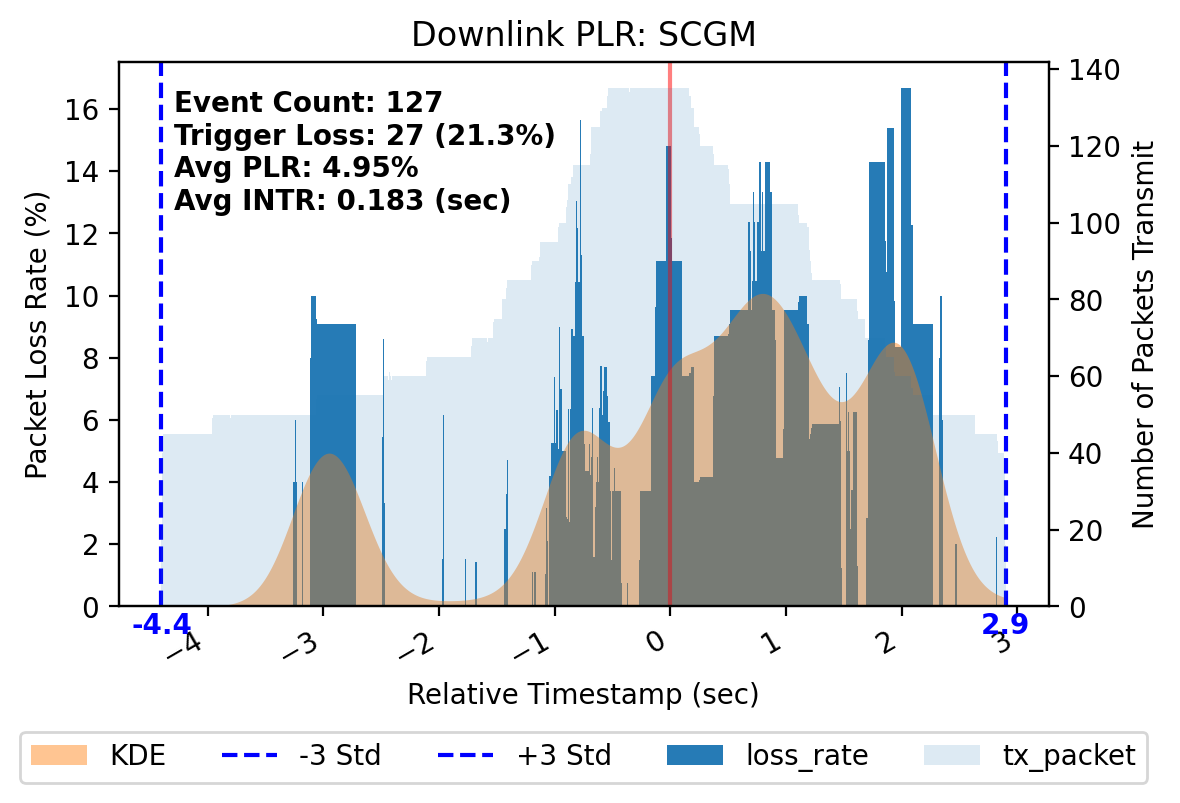

./20240403_01430006f4_test/dl_lost/models/plot/BR_SCGA.png


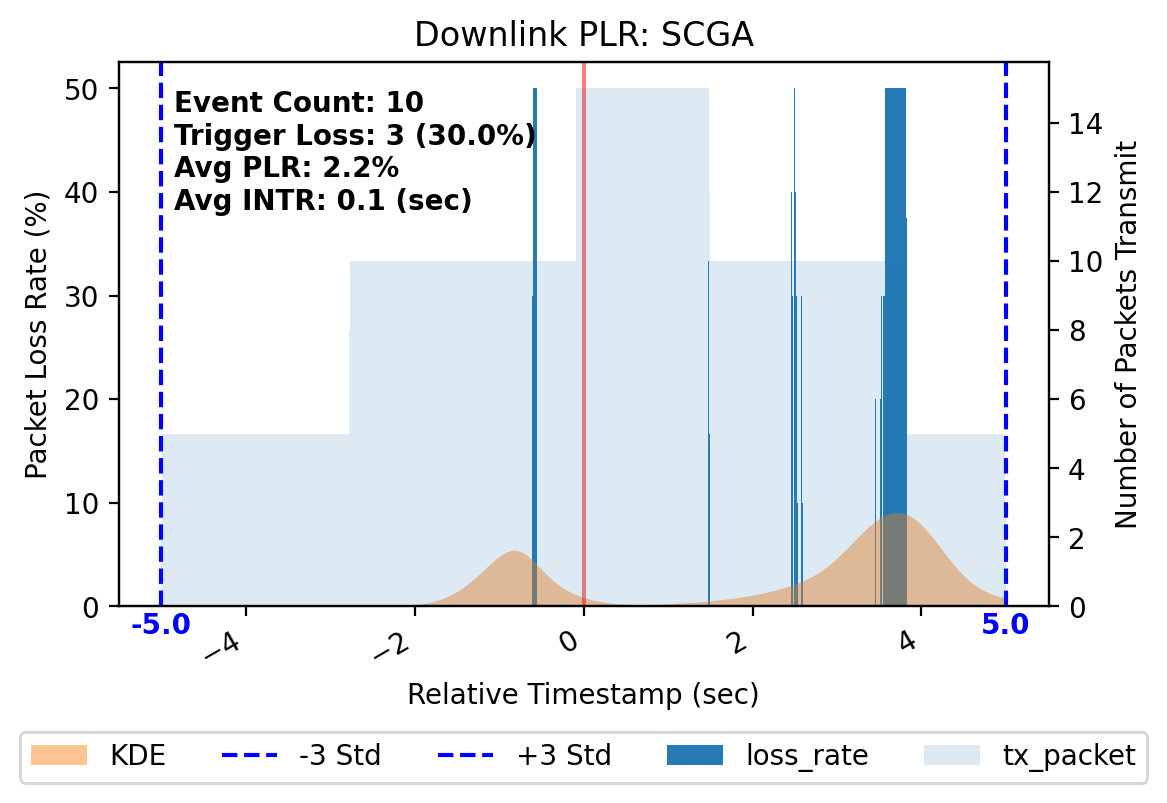

./20240403_01430006f4_test/dl_lost/models/plot/BR_SCGR-II.png


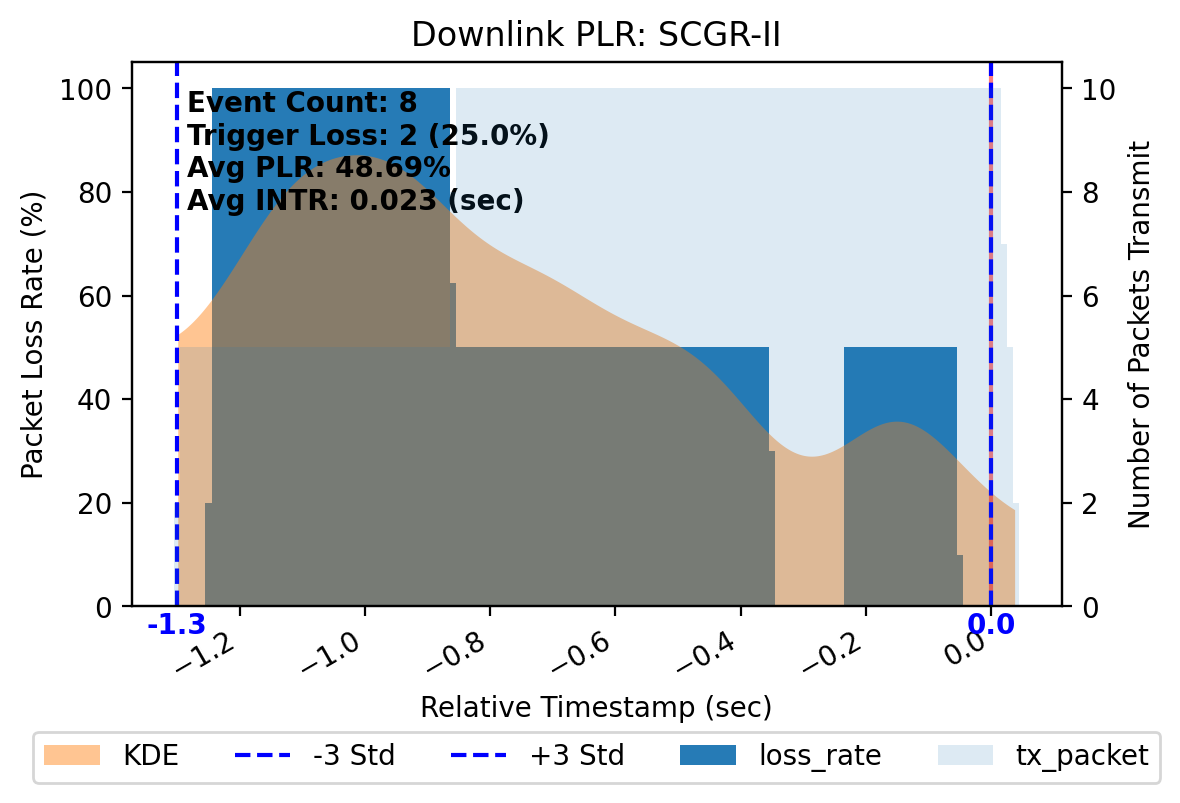

./20240403_01430006f4_test/dl_lost/models/plot/BR_SCGC-II.png


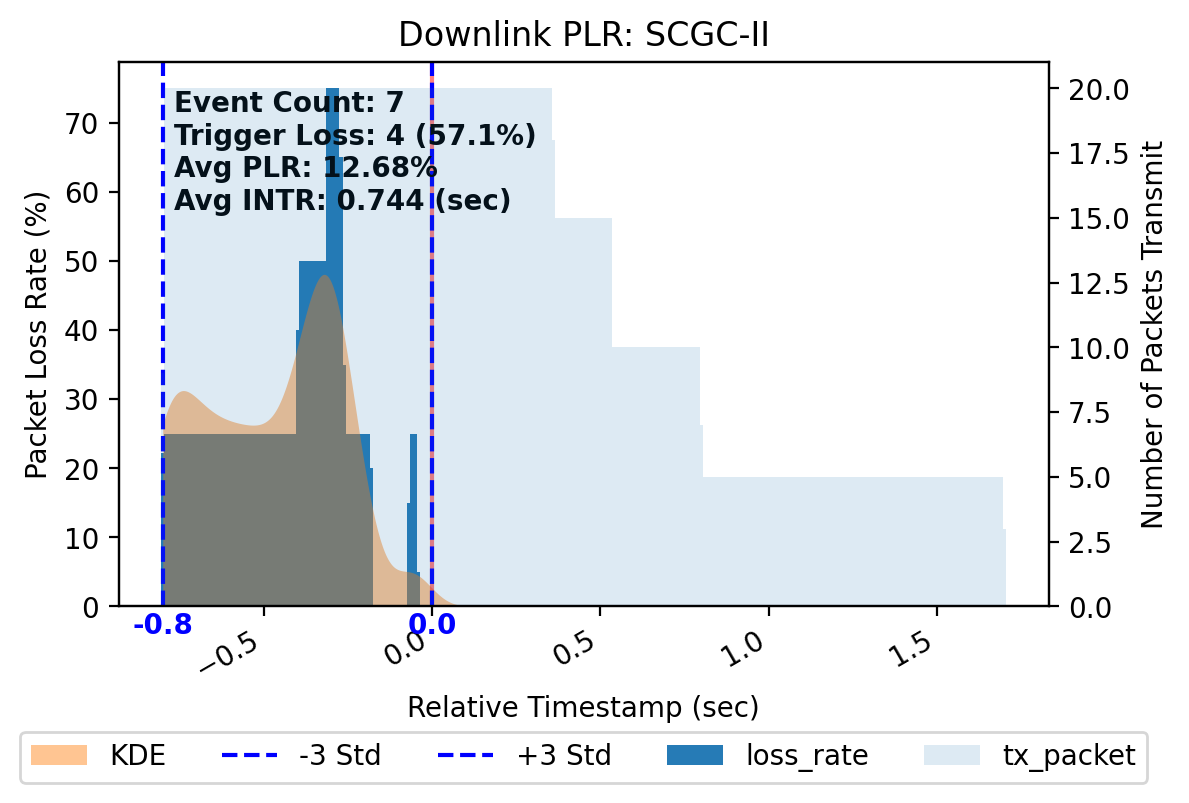

./20240403_01430006f4_test/dl_lost/models/plot/BR_SCGF.png


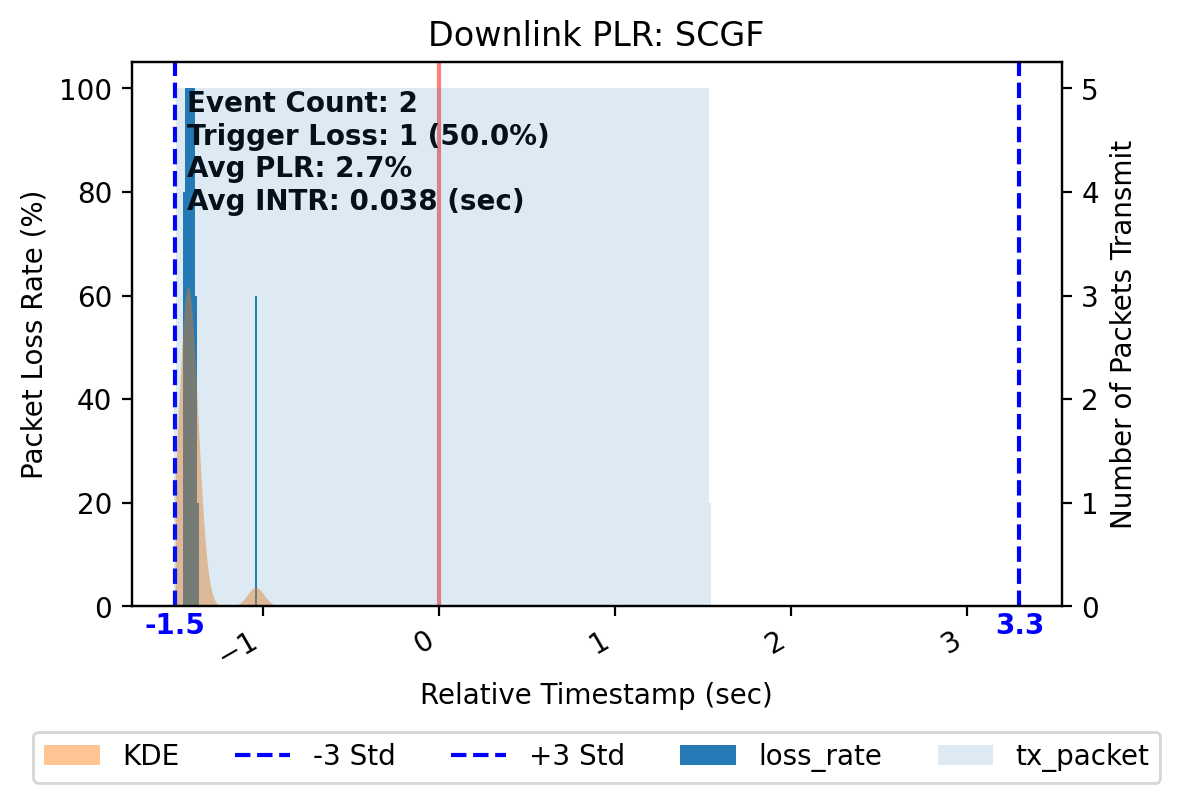

./20240403_01430006f4_test/dl_lost/models/plot/BR_MCGF.png


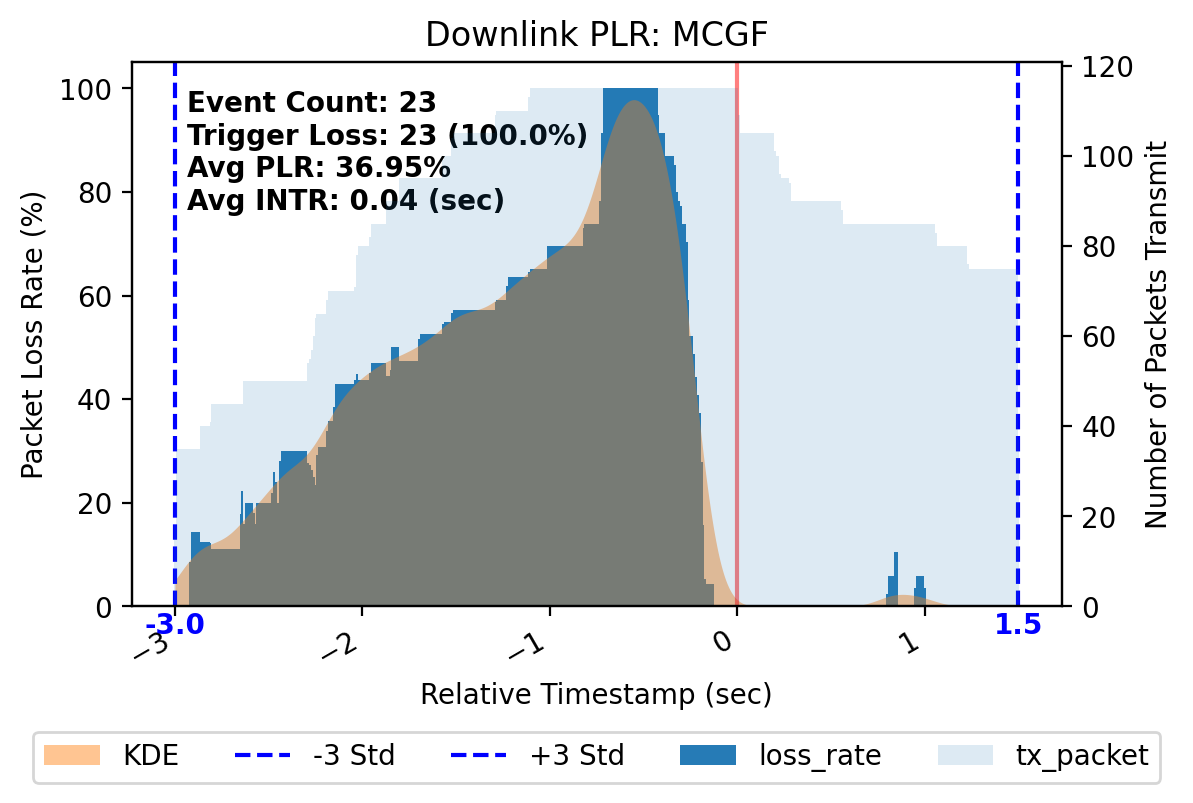

./20240403_01430006f4_test/dl_lost/models/plot/BR_Stable.png


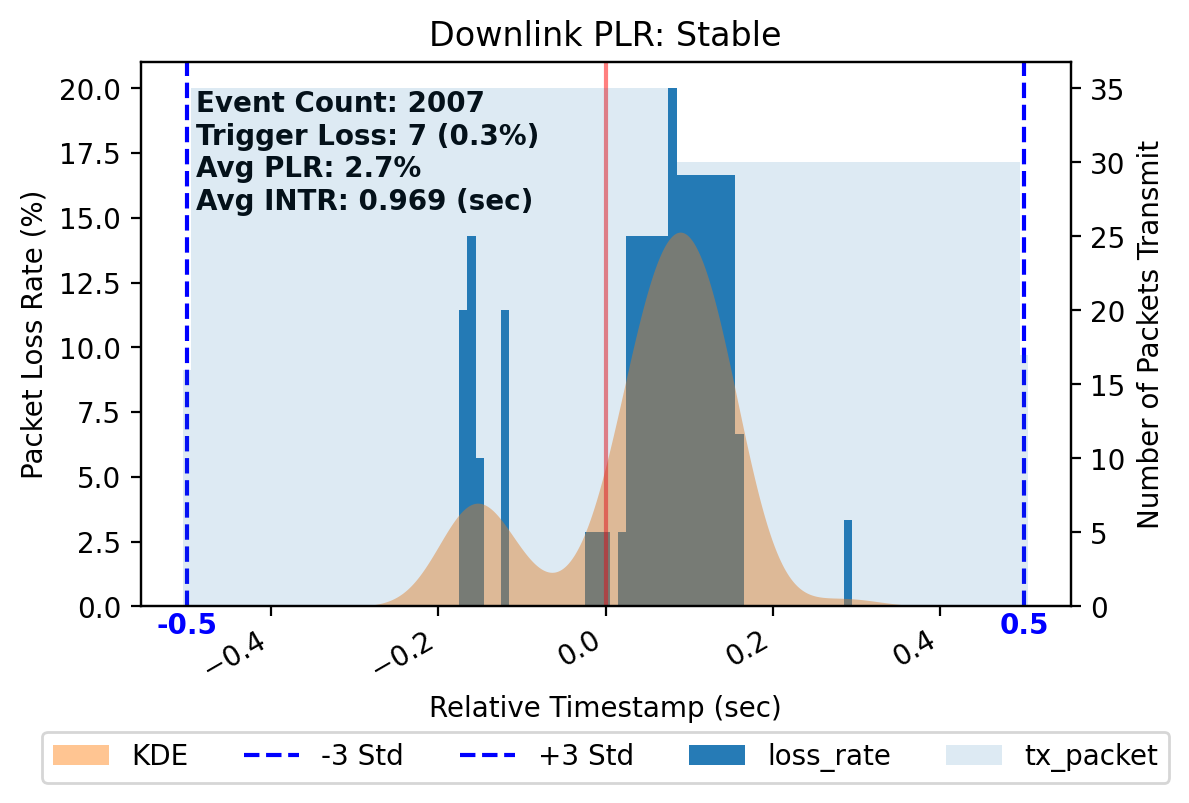

Save models: BR -> ./20240403_01430006f4_test/dl_lost/models



In [5]:
model = Profile(filepaths, 'BR', model_id, model_dscp, dirc_mets='dl_lost', epoch='1st')
model.plot()
model = Profile(filepaths, 'BR', model_id, model_dscp, scope=model.scope_models['result'], dirc_mets='dl_lost', epoch='last')
model.plot()
model.save_models()

# A Models

In [6]:
# Single Radio Example
# dates = data_loader(query_dates=True)

# selected_dates = [s for s in dates if s >= '2023-09-12']
selected_dates = ['2024-03-20']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['A']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

print(len(filepaths))
# pprint(filepaths)

18


. 20240403_01430006f4_test A 1st dl_lost
1/18 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/handover_info_log.csv
1/18 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_dnlk_loss_latency.csv


./20240403_01430006f4_test/dl_lost/models/plot/A_LTEH_1st.png


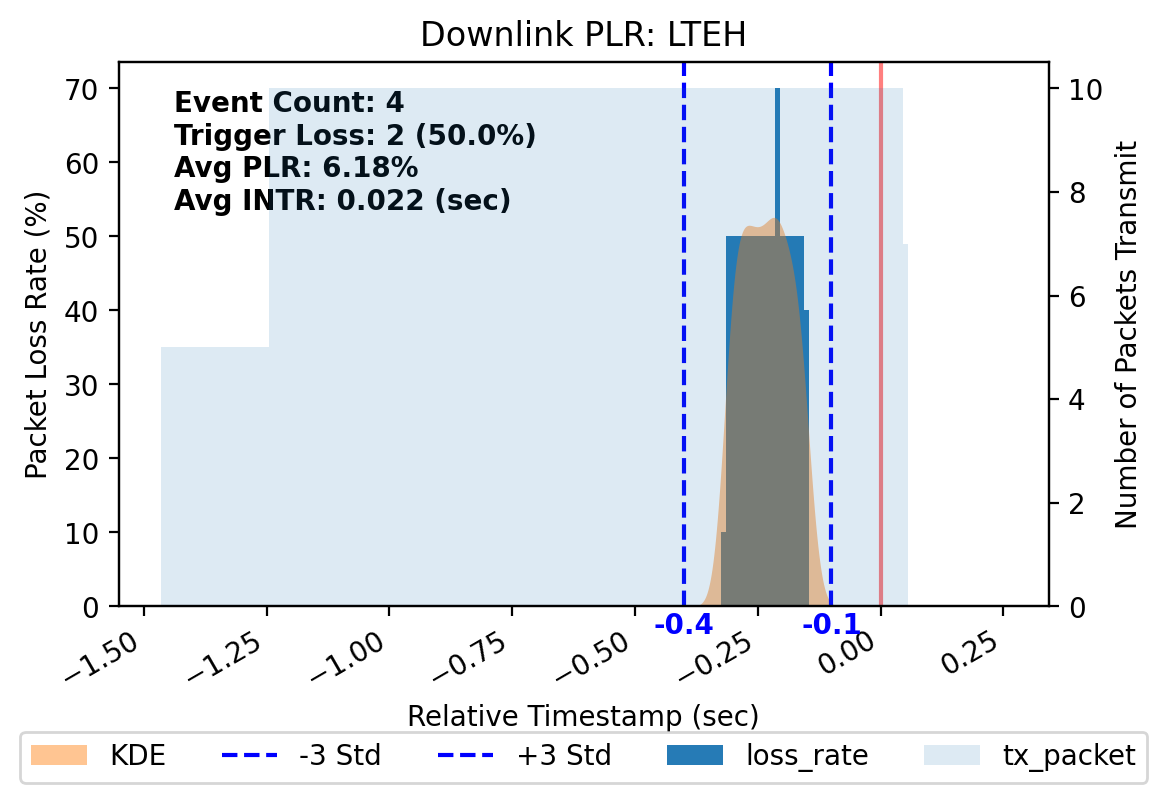

./20240403_01430006f4_test/dl_lost/models/plot/A_MCGH_1st.png


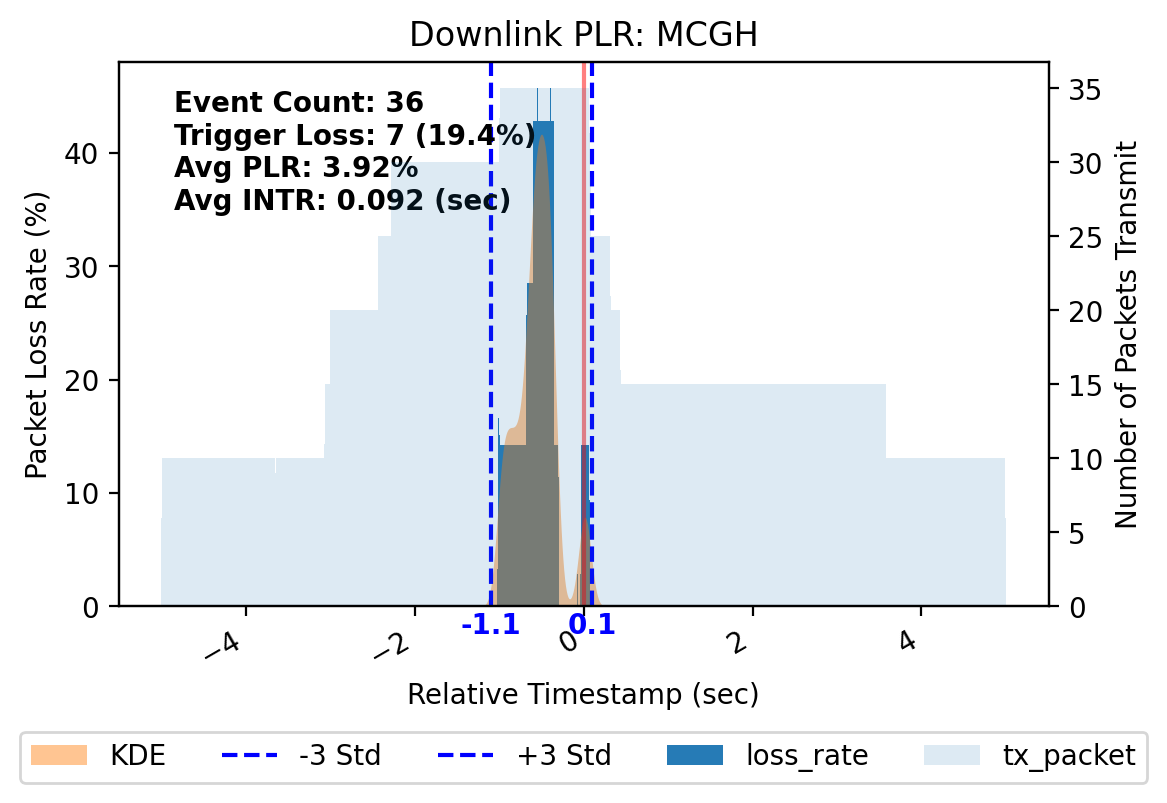

./20240403_01430006f4_test/dl_lost/models/plot/A_MNBH_1st.png


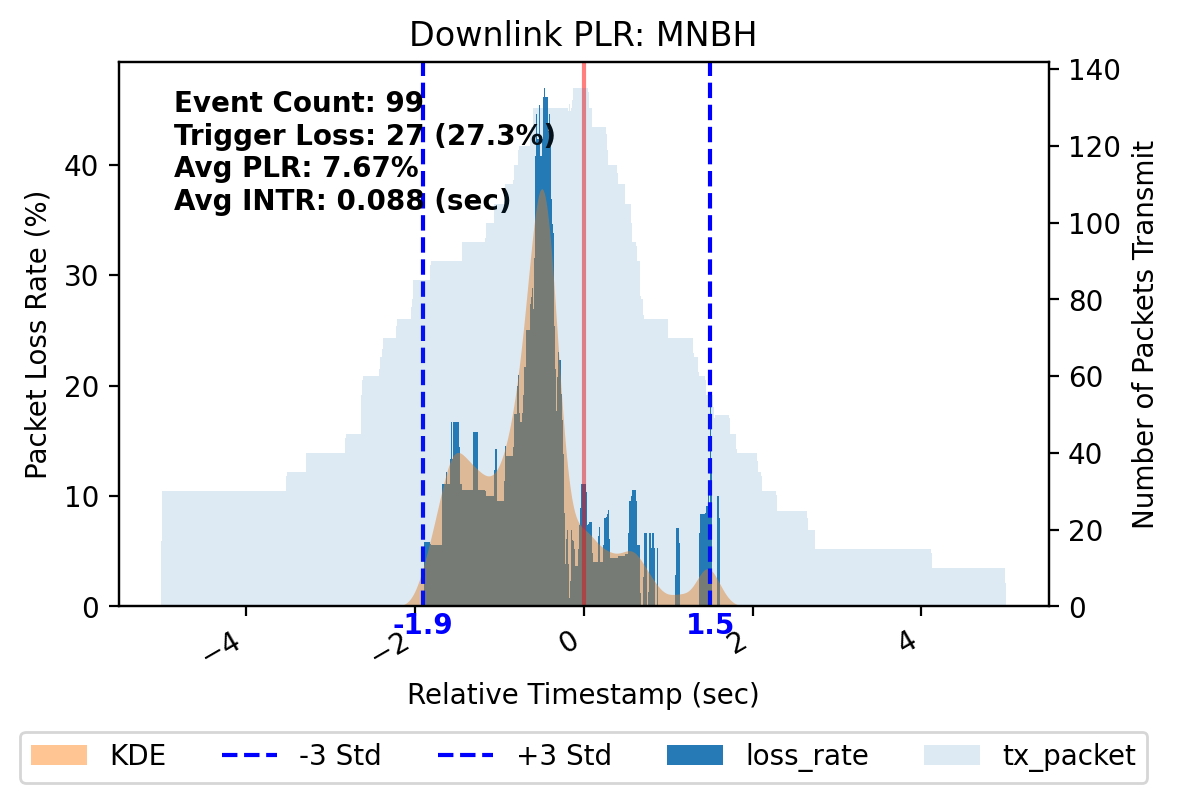

./20240403_01430006f4_test/dl_lost/models/plot/A_SCGM_1st.png


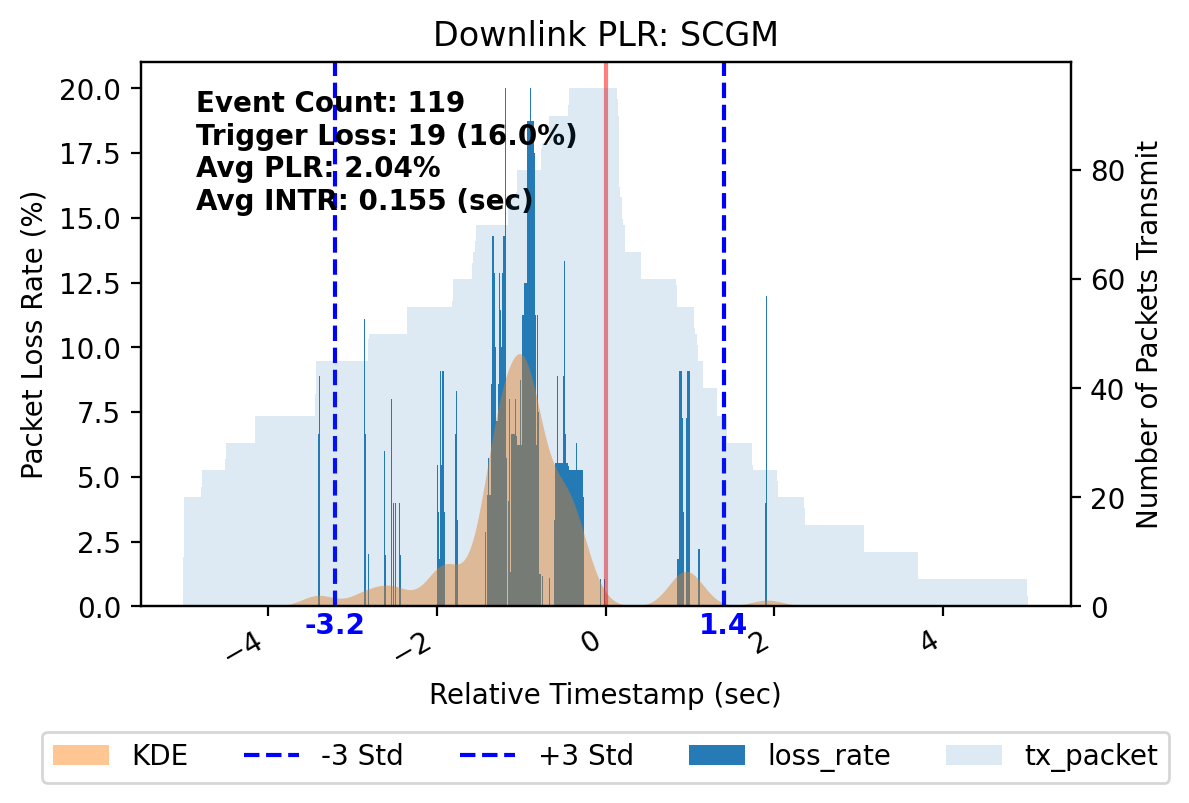

./20240403_01430006f4_test/dl_lost/models/plot/A_SCGA_1st.png


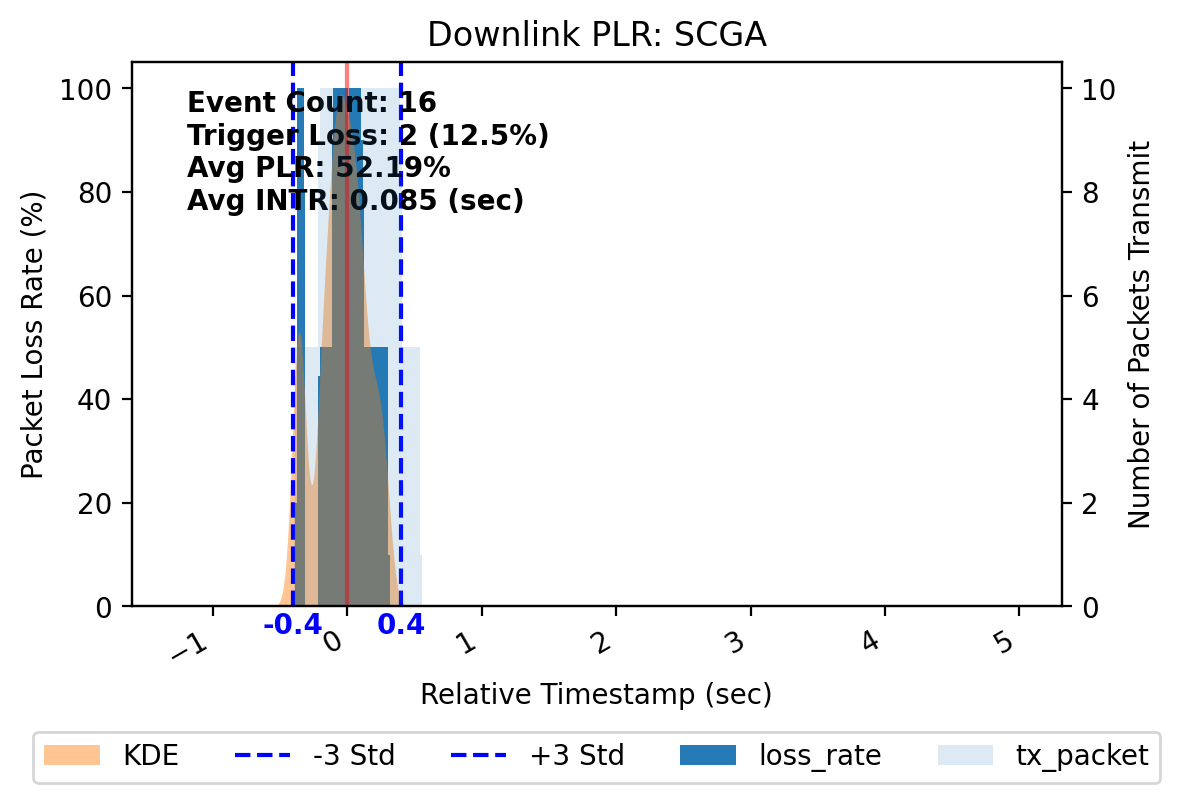

./20240403_01430006f4_test/dl_lost/models/plot/A_SCGR-I_1st.png


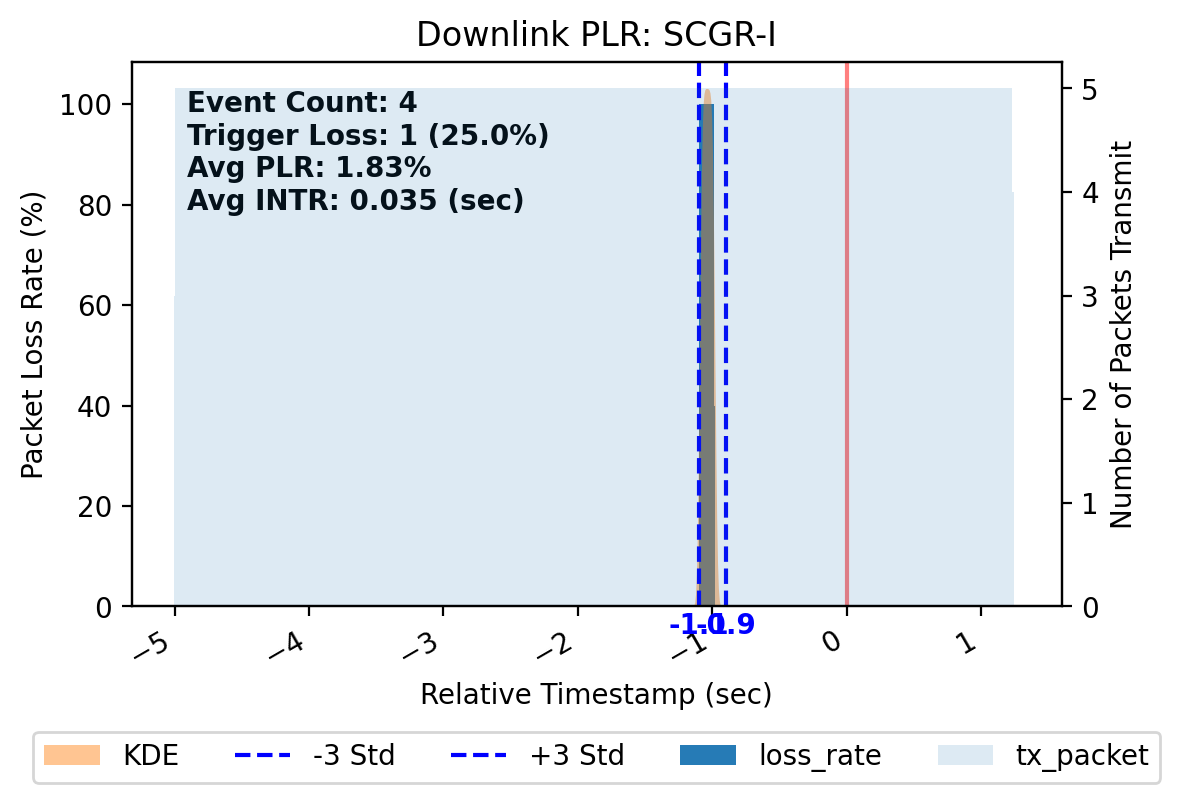

./20240403_01430006f4_test/dl_lost/models/plot/A_SCGR-II_1st.png


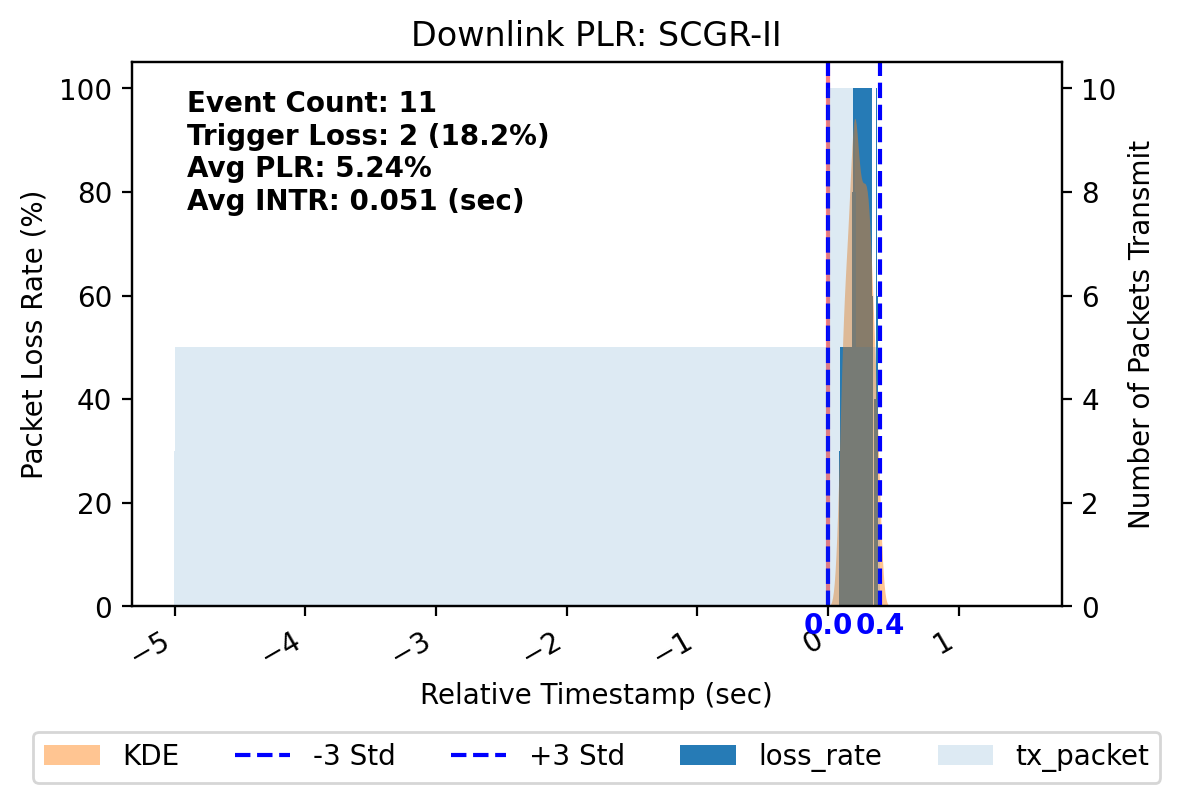

./20240403_01430006f4_test/dl_lost/models/plot/A_SCGC-I_1st.png


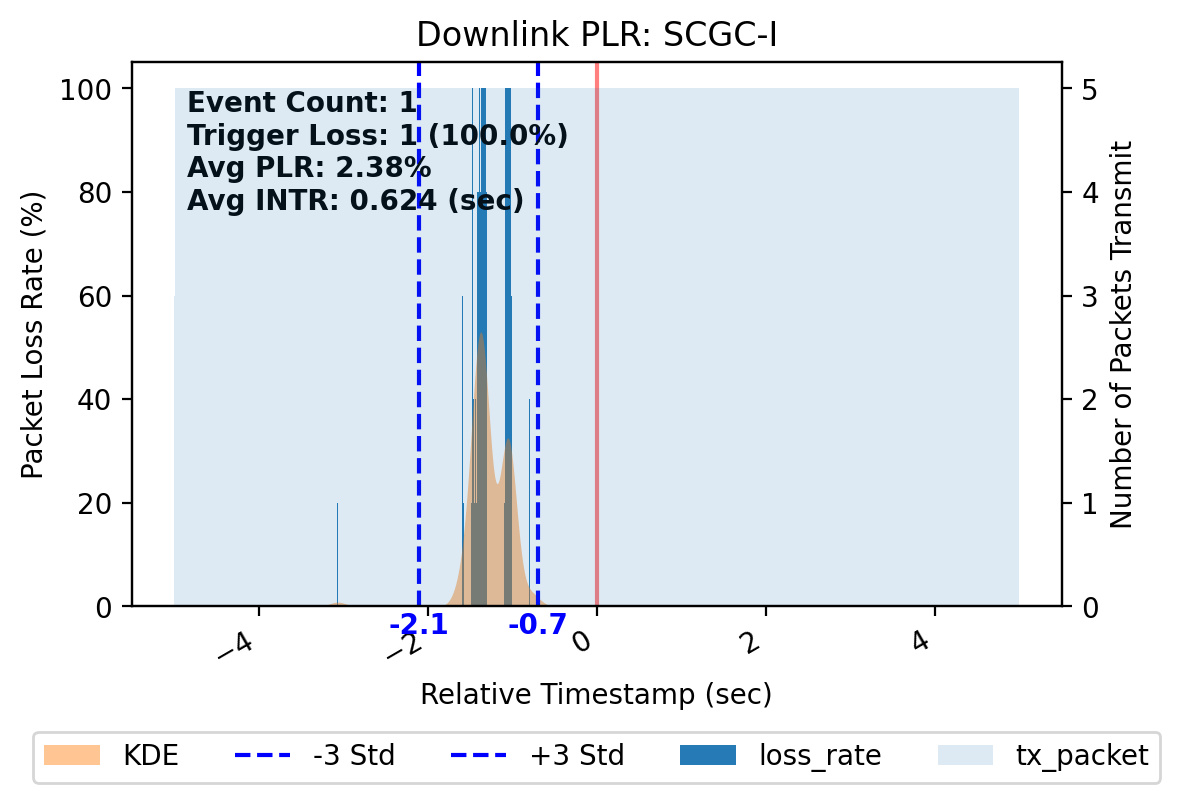

./20240403_01430006f4_test/dl_lost/models/plot/A_SCGC-II_1st.png


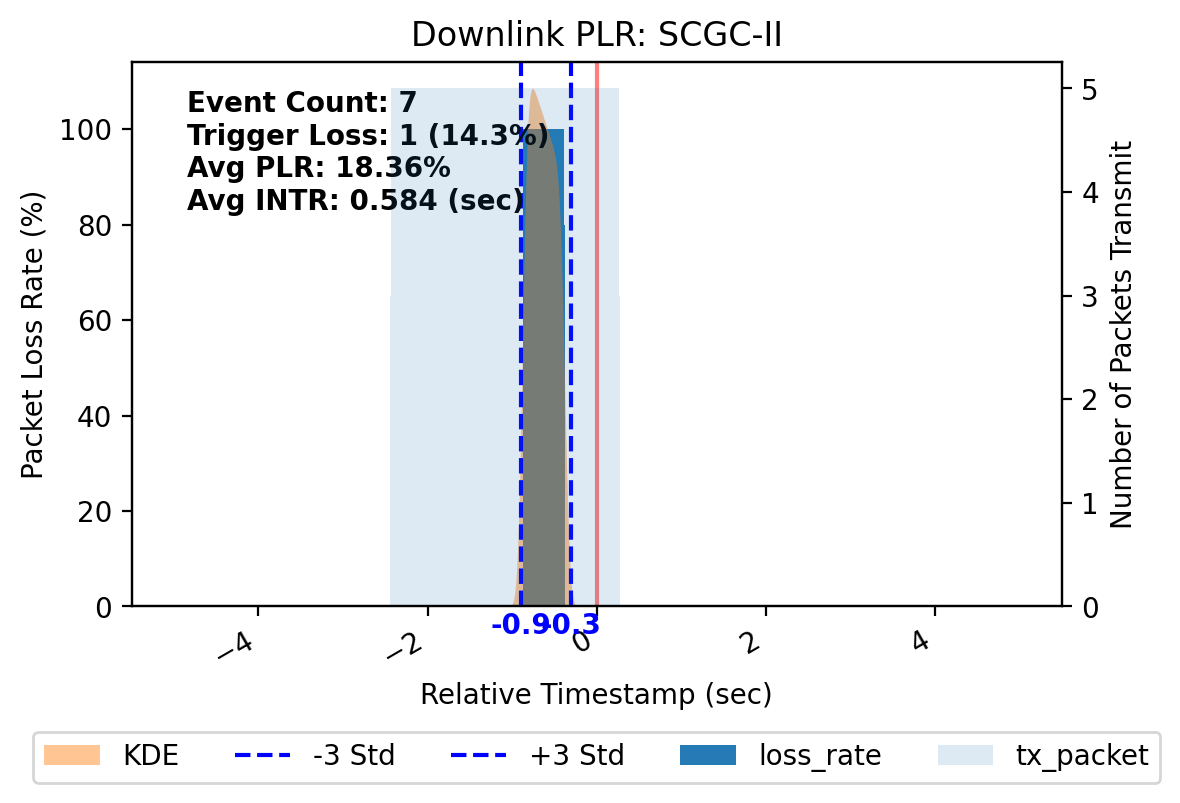

./20240403_01430006f4_test/dl_lost/models/plot/A_MCGF_1st.png


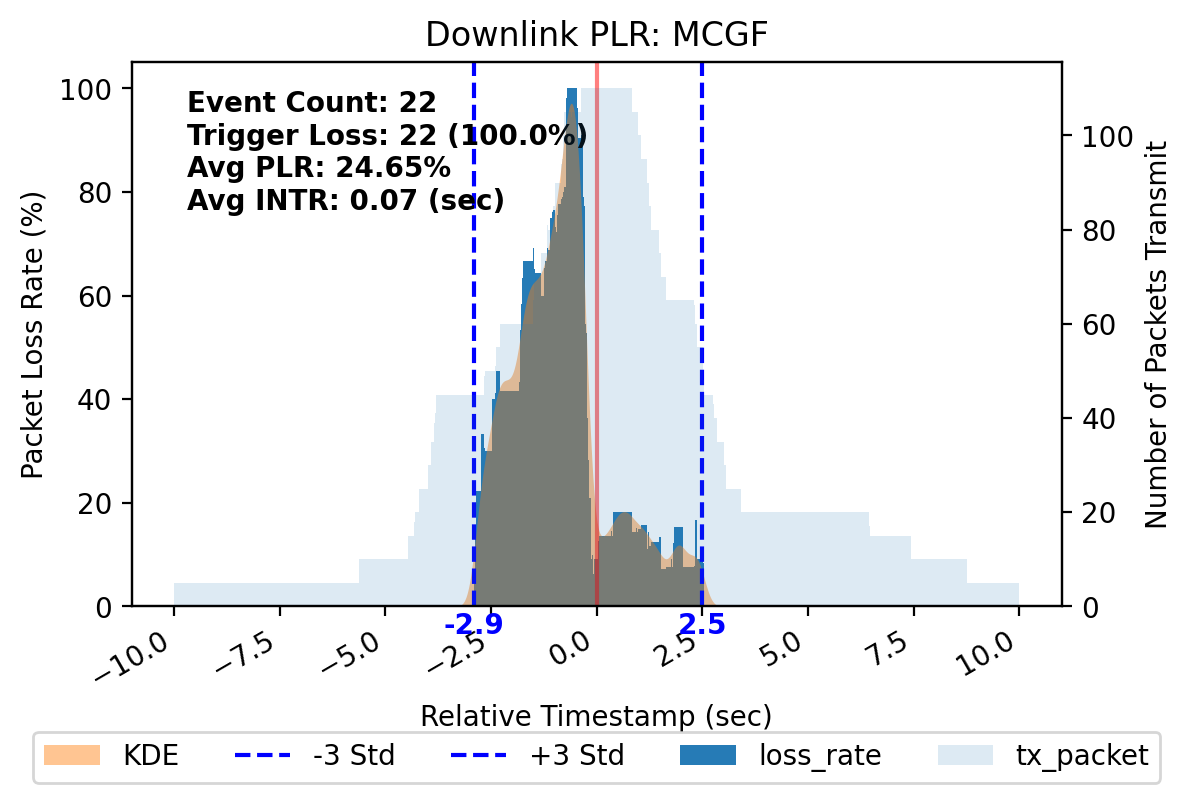

./20240403_01430006f4_test/dl_lost/models/plot/A_Stable_1st.png


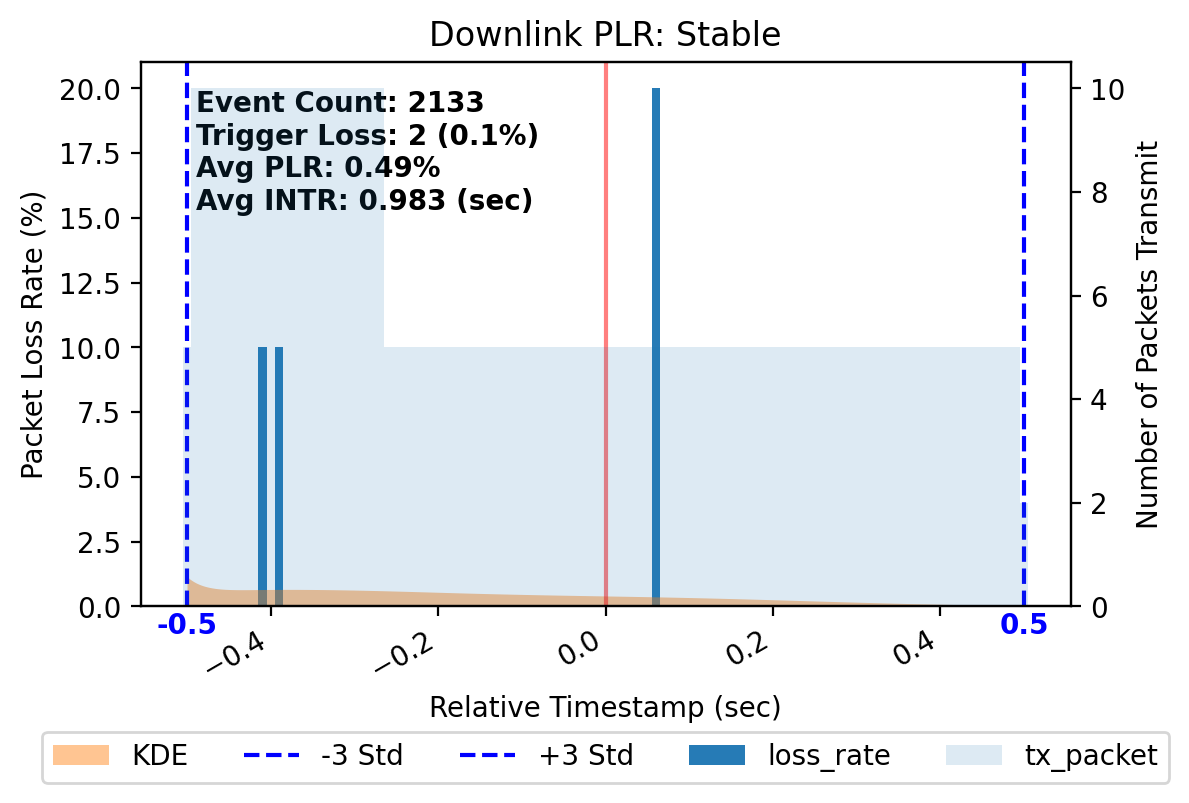

. 20240403_01430006f4_test A last dl_lost
1/18 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/handover_info_log.csv
1/18 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_dnlk_loss_latency.csv
./20240403_01430006f4_test/dl_lost/models/plot/A_LTEH.png


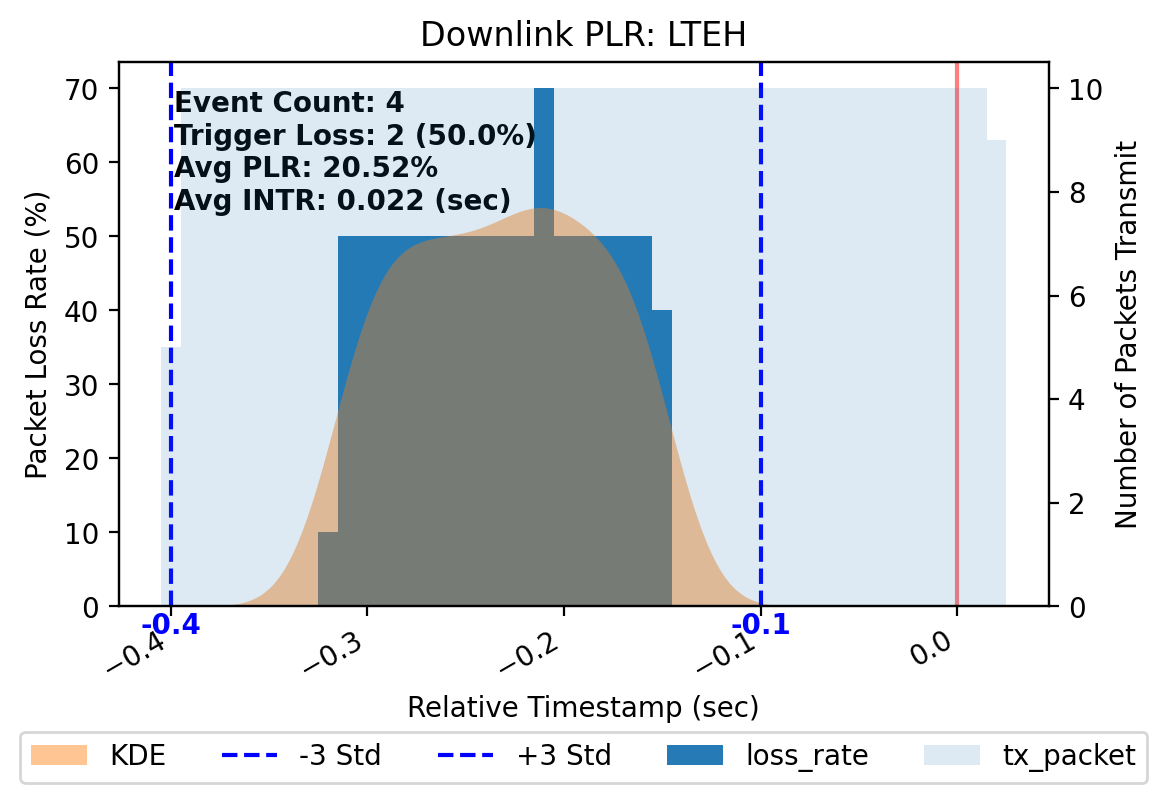

./20240403_01430006f4_test/dl_lost/models/plot/A_MCGH.png


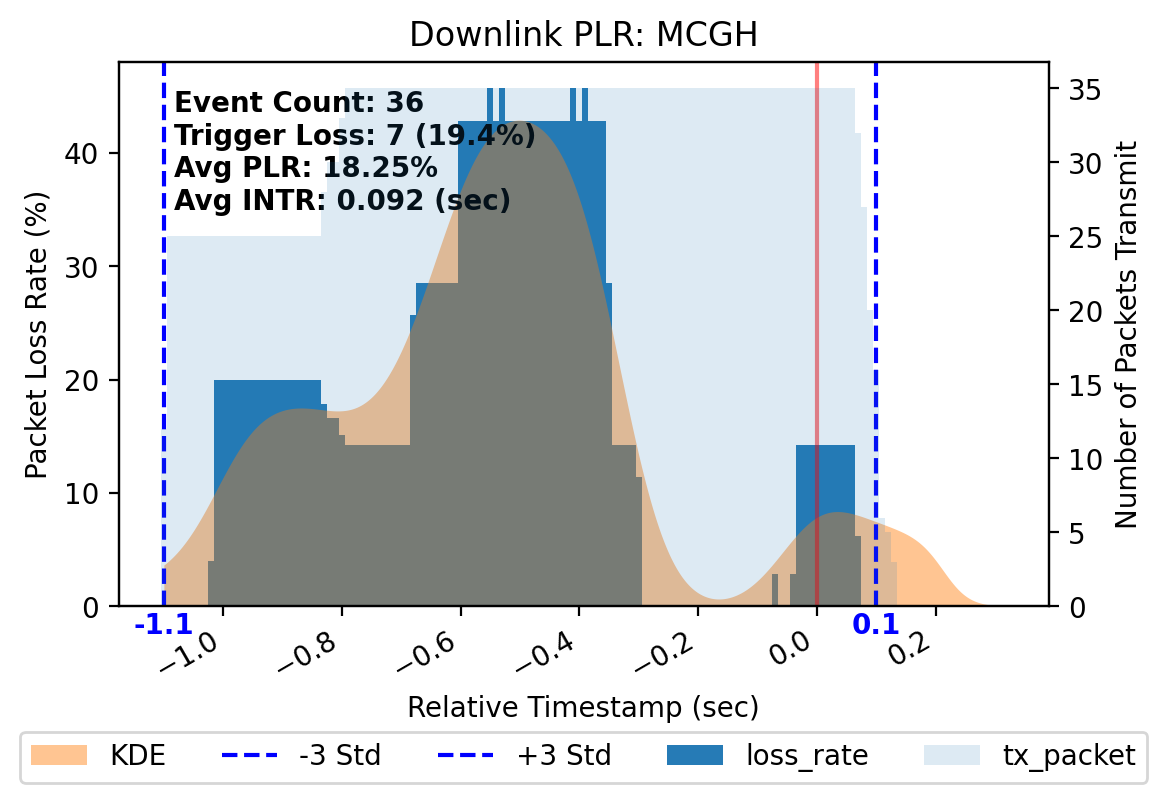

./20240403_01430006f4_test/dl_lost/models/plot/A_MNBH.png


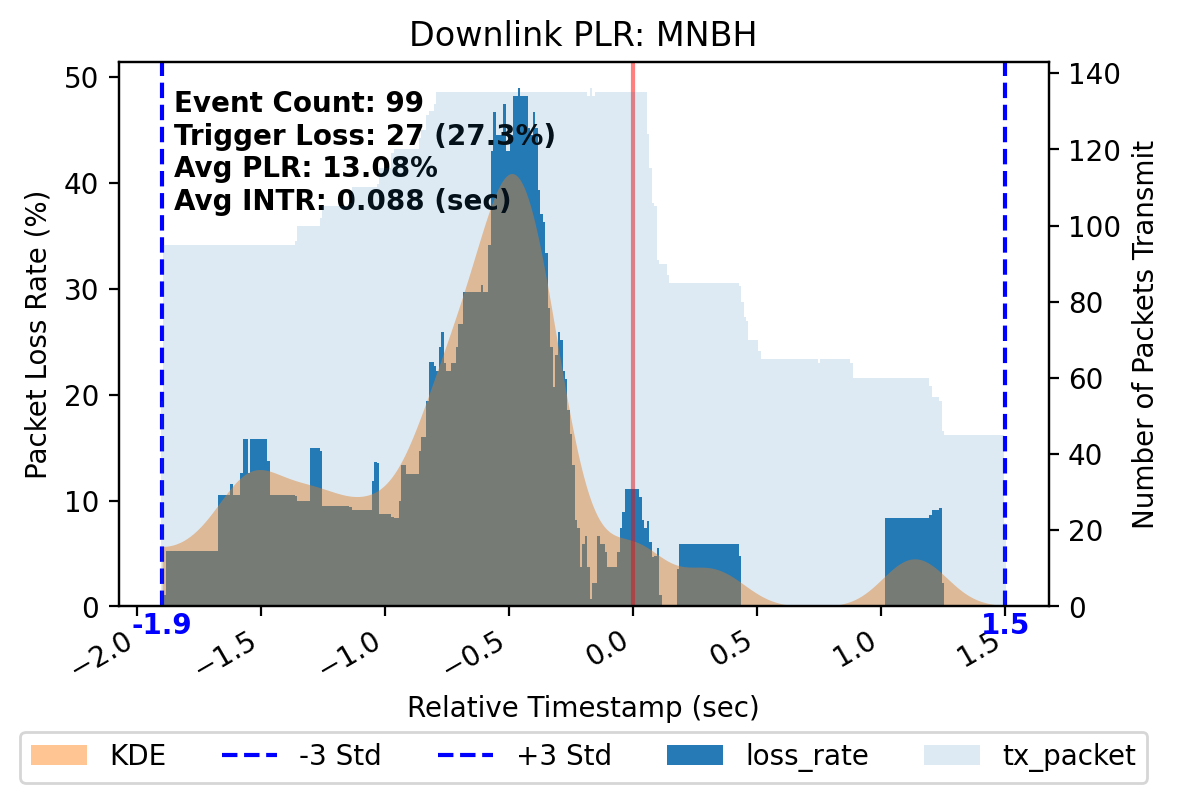

./20240403_01430006f4_test/dl_lost/models/plot/A_SCGM.png


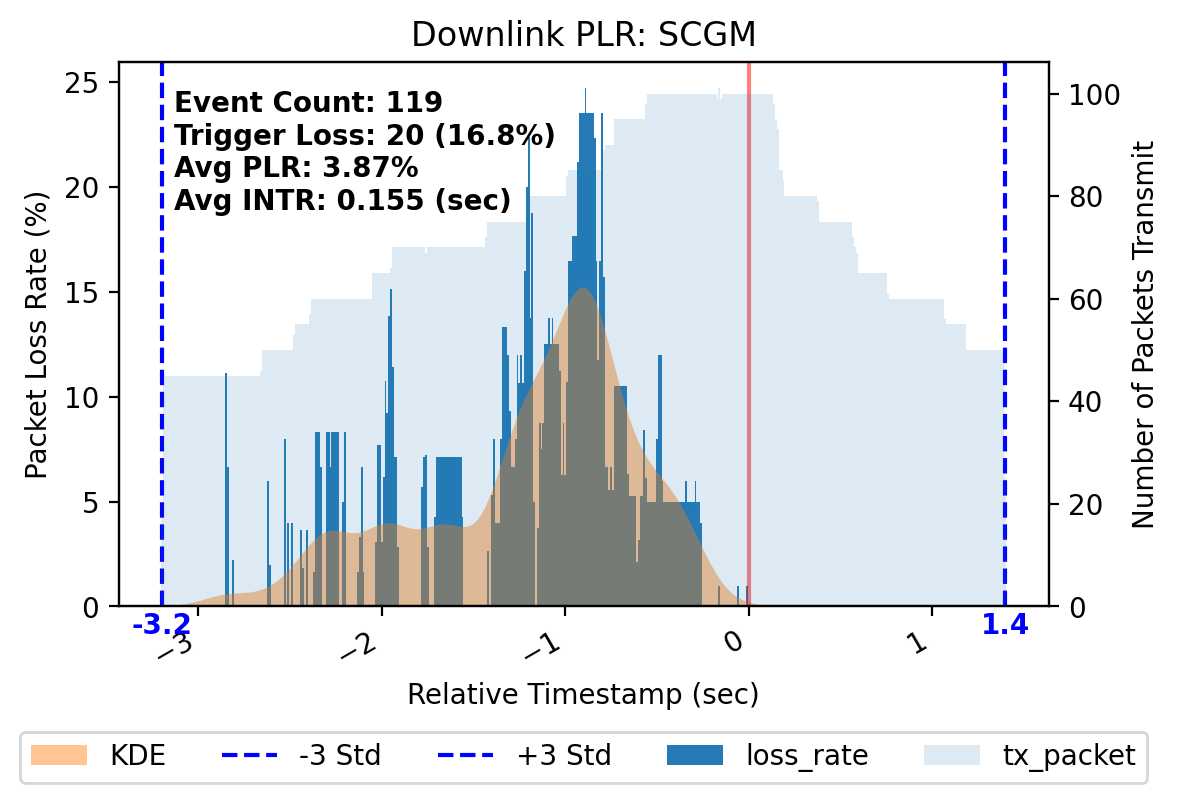

./20240403_01430006f4_test/dl_lost/models/plot/A_SCGA.png


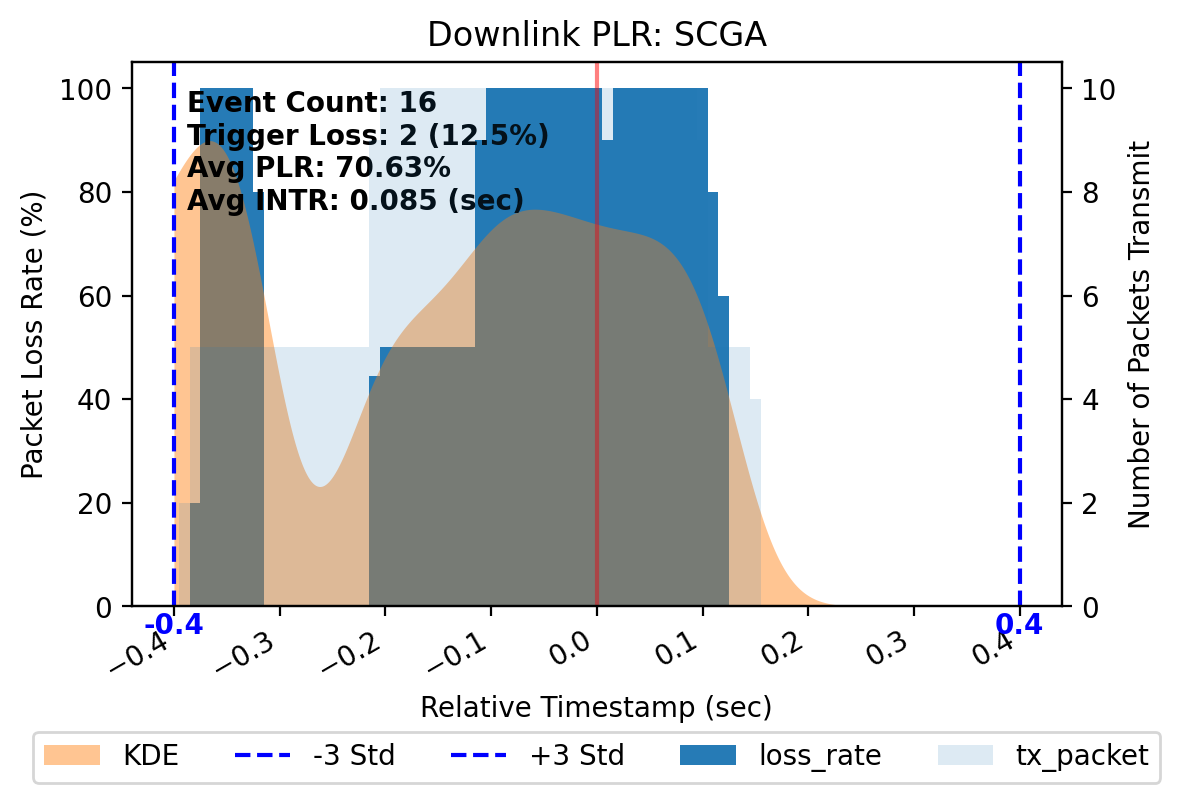

./20240403_01430006f4_test/dl_lost/models/plot/A_SCGR-I.png


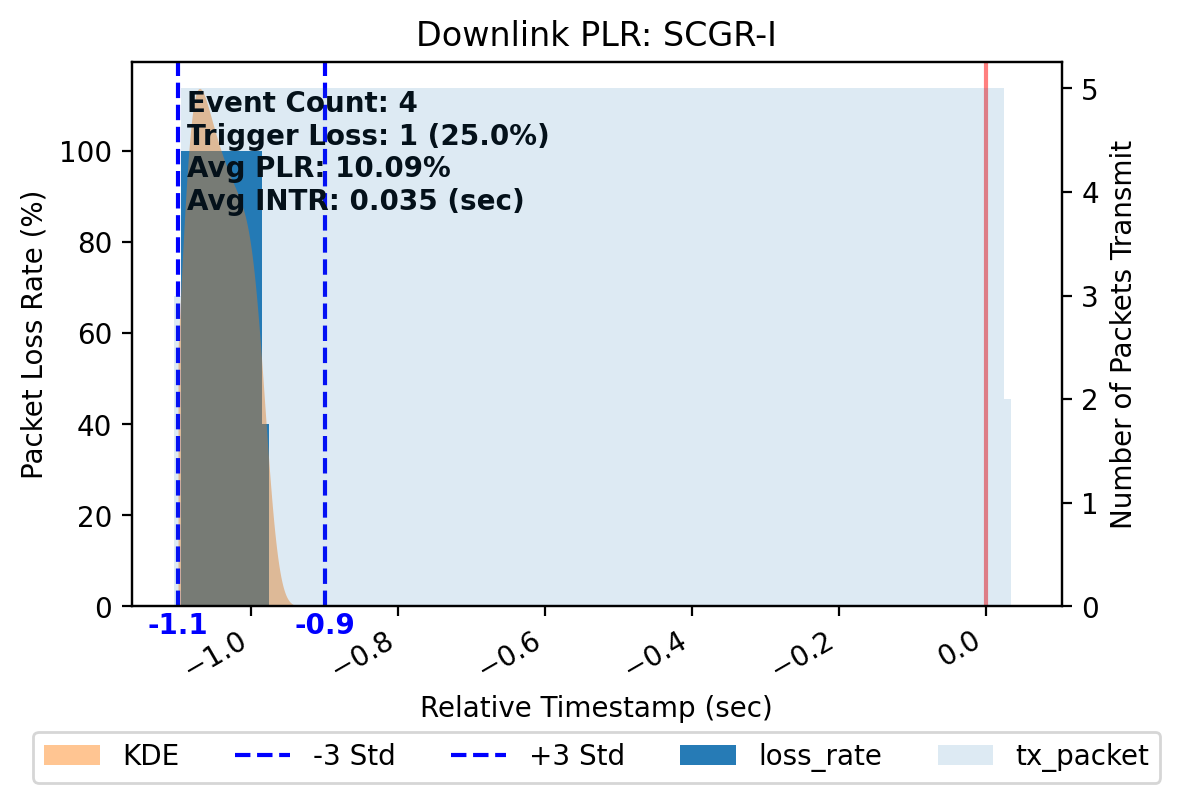

./20240403_01430006f4_test/dl_lost/models/plot/A_SCGR-II.png


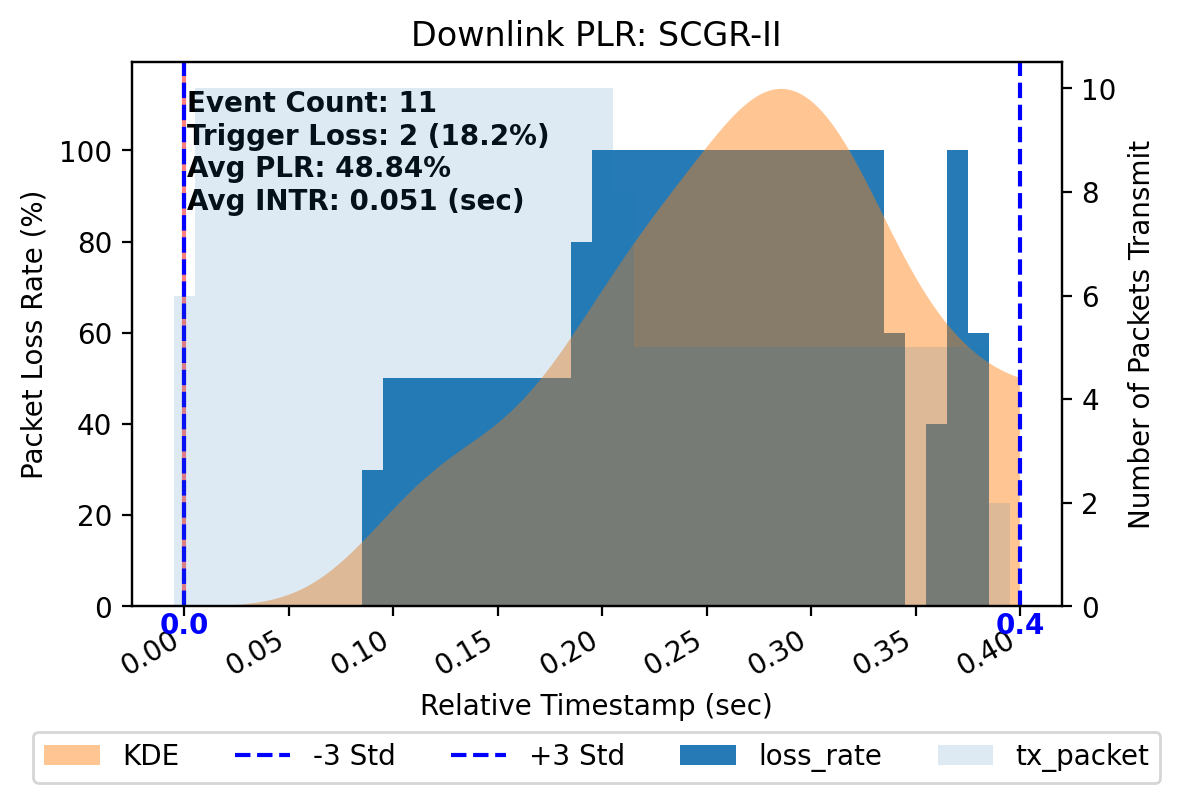

./20240403_01430006f4_test/dl_lost/models/plot/A_SCGC-I.png


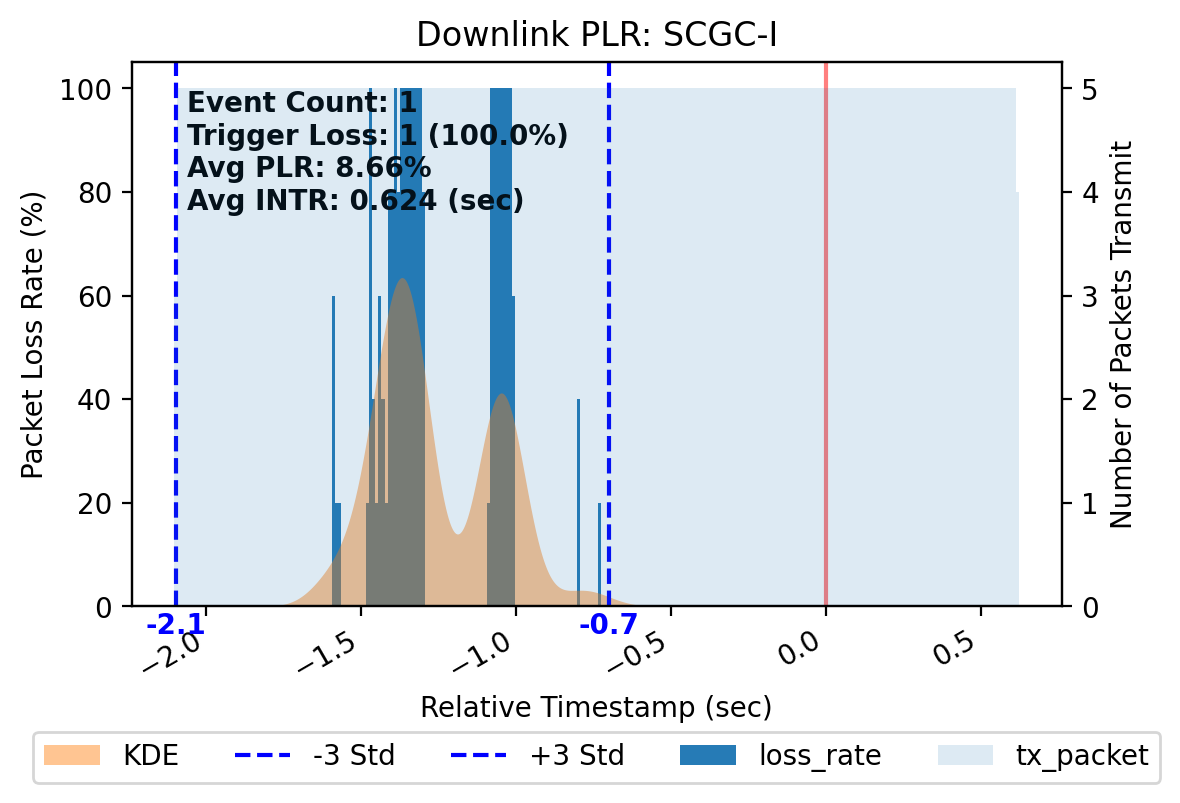

./20240403_01430006f4_test/dl_lost/models/plot/A_SCGC-II.png


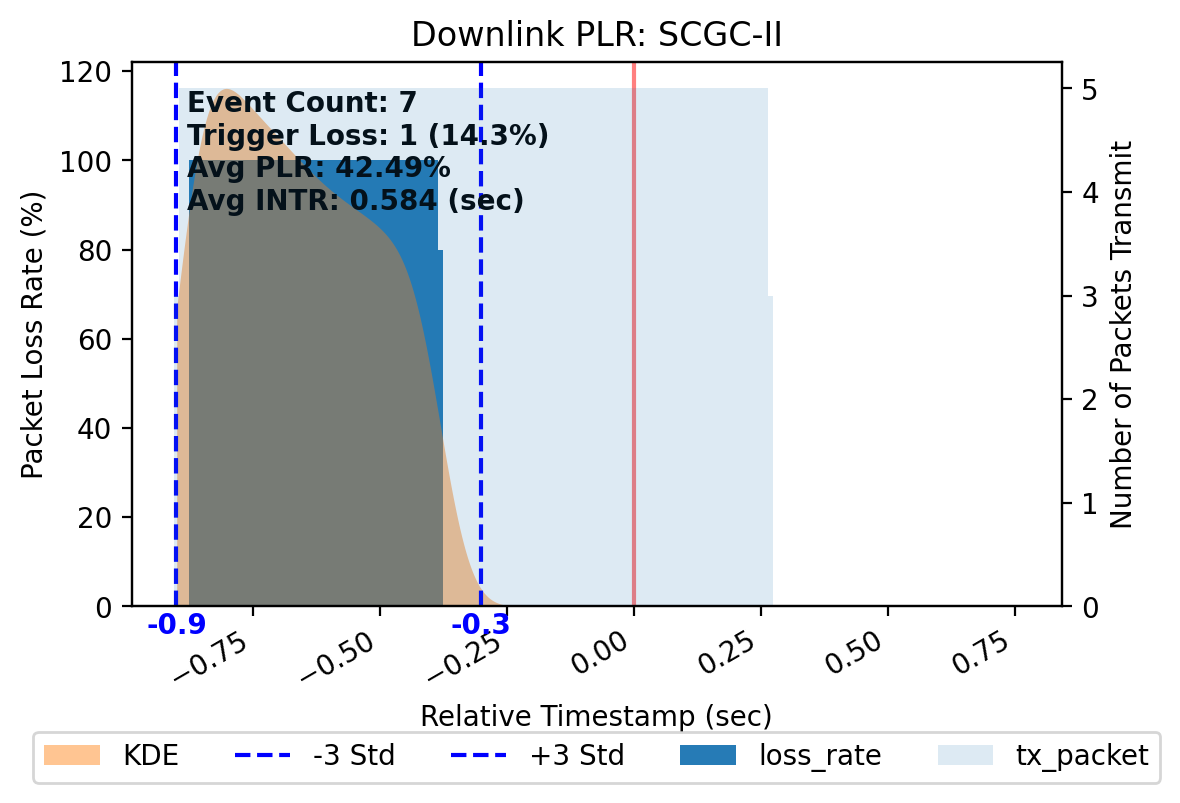

./20240403_01430006f4_test/dl_lost/models/plot/A_MCGF.png


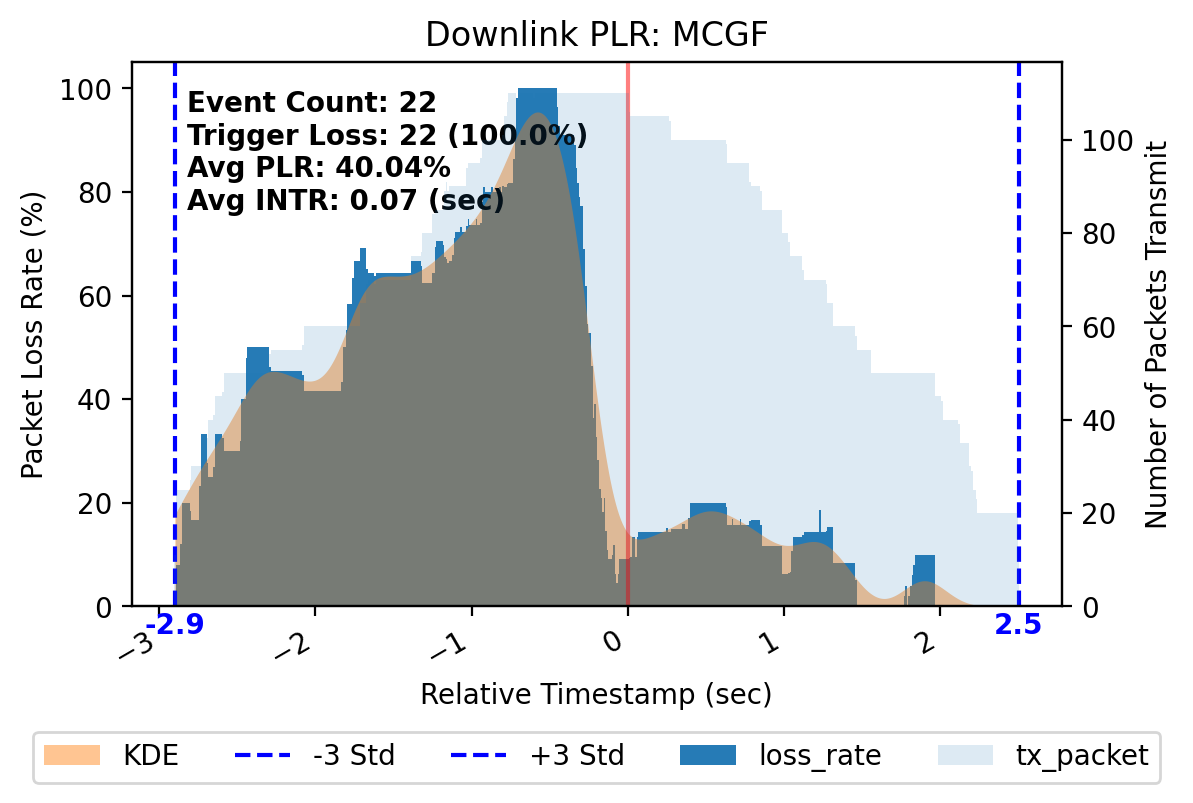

./20240403_01430006f4_test/dl_lost/models/plot/A_Stable.png


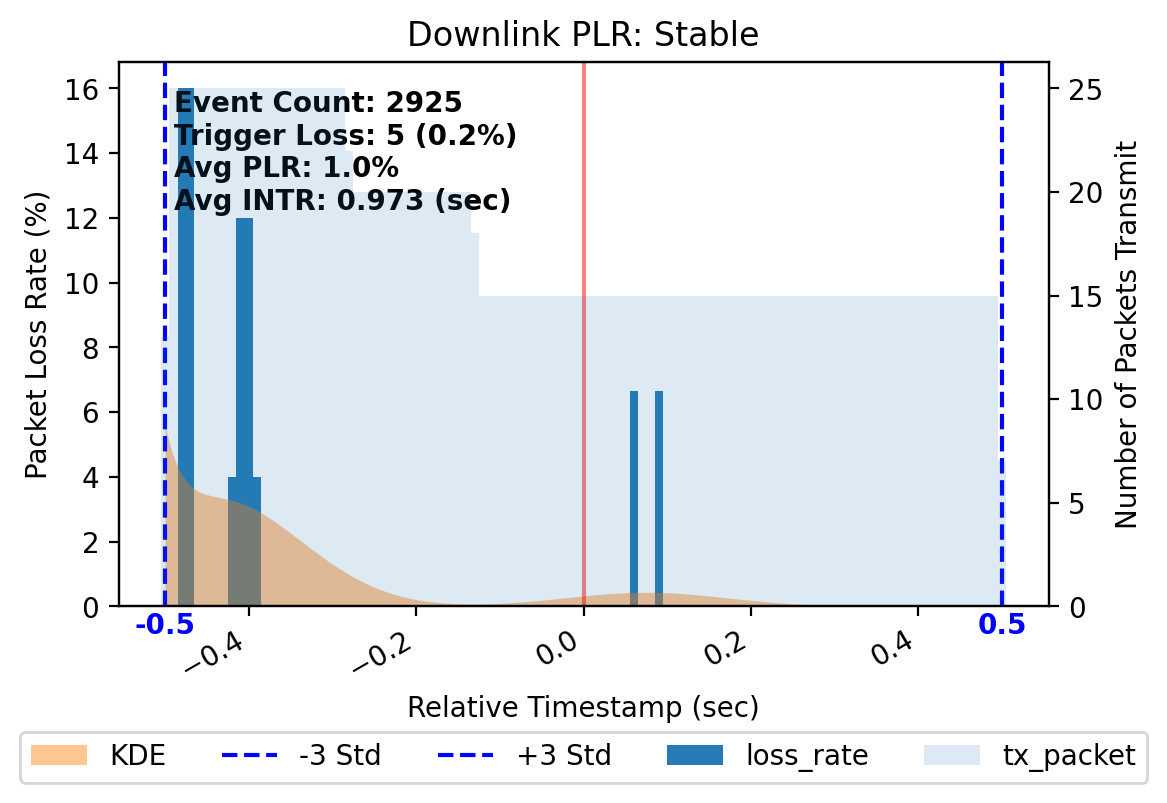

Save models: A -> ./20240403_01430006f4_test/dl_lost/models



In [7]:
model = Profile(filepaths, 'A', model_id, model_dscp, dirc_mets='dl_lost', epoch='1st')
model.plot()
model = Profile(filepaths, 'A', model_id, model_dscp, scope=model.scope_models['result'], dirc_mets='dl_lost', epoch='last')
model.plot()
model.save_models()

# Single Radio Evaluation

In [8]:
class Eval:
    def __init__(
        self, filepaths, model_prefix='Test',
        model_id=None, model_dscp=None, load_path='.', save_path='.',
        dirc_mets='dl_lost',
        sp_columns=['type'], ts_column='Timestamp',
        save_answer=False
    ):
        if model_id is None:
            raise TypeError("請輸入模型編號")
        
        self.filepaths = copy.deepcopy(filepaths)
        self.model_name = model_id if model_dscp is None else model_id + '_' + model_dscp
        self.model_prefix = model_prefix
        
        self.dirc_mets = dirc_mets
        self.dirc, self.mets = dirc_mets[:2], dirc_mets[-4:]
        self.DIRC_TYPE = 'Downlink' if self.dirc == 'dl' else 'Uplink'
        self.METS_TYPE = 'Packet Loss' if self.mets == 'lost' else 'Excessive Latency'
        self.RATE_TYPE = 'PLR' if self.mets == 'lost' else 'ELR'
        self.sp_columns = sp_columns[:]
        self.ts_column = ts_column
        self.save_answer = save_answer
        
        self.save_path = save_path
        self.load_path = os.path.join(load_path, self.model_name, self.dirc_mets, 'models', self.model_prefix)
        print(self.load_path)
        
        try:
            with open(f'{self.load_path}_kde_models.pkl', 'rb') as f:
                self.kde_models = pickle.load(f)[self.dirc_mets]
            with open(f'{self.load_path}_hist_models.pkl', 'rb') as f:
                self.hist_models = pickle.load(f)[self.dirc_mets]
            with open(f'{self.load_path}_scope_models.pkl', 'rb') as f:
                self.scope_models = pickle.load(f)[self.dirc_mets]
            with open(f'{self.load_path}_plr_models.pkl', 'rb') as f:
                self.plr_models = pickle.load(f)[self.dirc_mets]
            with open(f'{self.load_path}_sr_prob_models.pkl', 'rb') as f:
                self.prob_models = pickle.load(f)[self.dirc_mets]
        except:
            with open(f'{self.load_path}_kde_models.pkl', 'rb') as f:
                self.kde_models = pickle.load(f)
            with open(f'{self.load_path}_hist_models.pkl', 'rb') as f:
                self.hist_models = pickle.load(f)
            with open(f'{self.load_path}_scope_models.pkl', 'rb') as f:
                self.scope_models = pickle.load(f)['result']
            with open(f'{self.load_path}_plr_models.pkl', 'rb') as f:
                self.plr_models = pickle.load(f)
            with open(f'{self.load_path}_sr_prob_models.pkl', 'rb') as f:
                self.prob_models = pickle.load(f)
        
        self.date, self.hms_count, self.hex_string, self.figure_id = figure_identity()
        self.save_name = f'{self.model_prefix}_{self.date}_{self.hms_count}_{self.hex_string}'
        self.records = []

    @staticmethod
    def generate_random_boolean(probability_true):
        return random.random() < probability_true
    
    @staticmethod
    def interpolate(x, y, ratio=0.5):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio
    
    def hist_method(self, df, ho_df):
        mets, RATE_TYPE = self.mets, self.RATE_TYPE
        scope = self.scope_models
        hist_model = self.hist_models
        prob_model = self.prob_models
        
        this_df = df.copy()
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, Eval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, Eval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, Eval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, Eval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            # Concatenate PLR from mapping list
            current_df = this_df[this_df['Timestamp'] < interval.upper].copy()
            plr_mapping = hist_model[tag].copy()
            
            current_df[f'relative_time'] = (current_df['Timestamp'] - start_ts).dt.total_seconds()
            current_df[f'window_id'] = ((current_df[f'relative_time'] + 0.005) // 0.01) * 0.01
            
            trigger_probability = prob_model[tag]
            
            if plr_mapping.empty:
                tmp = current_df.copy().rename(columns={mets: f'{mets}_x'})
            else:
                tmp = pd.merge(current_df, plr_mapping, on='window_id', how='left')
                tmp[RATE_TYPE] = tmp[RATE_TYPE].fillna(0)
                
                if not Eval.generate_random_boolean(trigger_probability):
                    tmp[RATE_TYPE] = 0
            
            tmp['type'] = tag
            
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
        
        answer = pd.concat([answer, this_df], axis=0)
        
        # Consider stable duration
        stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = hist_model['Stable'].copy()        
        stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_if_trigger'})
        trigger_prob_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)[['Timestamp_sec']]
        
        trigger_probability = prob_model['Stable']
        random_bool_array = [Eval.generate_random_boolean(trigger_probability) for _ in range(len(trigger_prob_mapping))]
        trigger_prob_mapping['trigger'] = random_bool_array

        stable_df = pd.merge(stable_df, trigger_prob_mapping, on='Timestamp_sec', how='left')
        stable_df['PLR'] = stable_df['PLR_if_trigger'] * stable_df['trigger']
        
        stable_df['type'] = 'Stable'

        del stable_df['Timestamp_sec'], stable_df['PLR_if_trigger'], stable_df['trigger']
        
        answer = answer[answer['tx_count'].notnull()].copy()
        
        answer = pd.concat([answer, stable_df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(Eval.generate_random_boolean)
        
        eval_value = answer['Y'].mean() * 100
        ground_value = df['lost'].mean() * 100
        
        answer = pd.concat([answer[['seq', 'Timestamp', 'type', 'relative_time', 'window_id']],
                            df[['lost']],
                            answer[[RATE_TYPE, 'Y']]], axis=1)
        
        return answer, eval_value, ground_value
    
    
    def run_hist_method(self, N=5):
        dirc, mets = self.dirc, self.mets
        n = len(self.filepaths)
        
        for i, filepath in enumerate(self.filepaths):
            
            # if i > 0:
            #     break
            
            path = filepath[1] if dirc == 'dl' else filepath[2]
            print(f'{i+1}/{n}', filepath[0]); print(f'{i+1}/{n}', path)
            
            if os.path.isfile(filepath[0]):
                ho_df = generate_dataframe(filepath[0], parse_dates=['start', 'end'])
            else:
                print('{} does not exist!!!'.format(filepath[0]))
                print('makefile:', filepath[0])
                ho_df, _ = mi_parse_handover(generate_dataframe(filepath[3], parse_dates=['Timestamp']))
                ho_df.to_csv(filepath[0], index=False)
            
            if ho_df.empty:
                print('*************** EMPTY HO INFO ***************')
                continue
            
            if dirc == 'dl':
                df = generate_dataframe(filepath[1], parse_dates=['Timestamp'], usecols=['seq', 'Timestamp', 'lost', 'excl', 'latency'])
            else:
                df = generate_dataframe(filepath[2], parse_dates=['Timestamp'], usecols=['seq', 'Timestamp', 'lost', 'excl', 'latency'])
                
            df, ho_df, empty_data = data_aligner(df, ho_df)
            
            if empty_data:
                print('*************** EMPTY DATA ***************')
                continue
            
            loss_rate_list = []
            answer = None
            for iter_round in tqdm(range(N), ncols=1000):
                ans, eval_value, ground_value = eval.hist_method(df, ho_df)
                
                if answer is None:
                    answer = ans.copy()
                    answer = answer.rename(columns={'PLR': f'PLR_0', 'Y': f'Y_0'})
                else:
                    answer = pd.concat([answer, ans[['PLR', 'Y']]], axis=1)
                    answer = answer.rename(columns={'PLR': f'PLR_{iter_round}', 'Y': f'Y_{iter_round}'})
                
                loss_rate_list.append(eval_value)
            
            # display(answer)

            def remove_min_max(nums, epsilon=1e-9):
                if len(nums) < 5:
                    return nums
                min_val = min(nums)
                max_val = max(nums)
                nums = [num for num in nums if abs(num - min_val) > epsilon and abs(num - max_val) > epsilon]
                return nums
            
            loss_rate_list_rmm = remove_min_max(loss_rate_list)
            mean_value = np.mean(loss_rate_list_rmm)
            std_deviation = np.std(loss_rate_list_rmm)
            error = mean_value - ground_value

            # print()
            # print("Mean:", mean_value)
            # print("Standard Deviation:", std_deviation)
            # print("Ground Truth:", ground_value)
            # print("Error:", error)

            path = filepath[1] if dirc == 'dl' else filepath[2]
            
            sm_index = path.index("sm")  # 找到 "sm" 的位置
            next_slash_index = path.index("/", sm_index)  # 从 "sm" 的位置开始找到下一个斜杠 "/"
            sm_dev = path[sm_index:next_slash_index]  # 截取 "sm00" 标签
            
            sm_index = path.index("#")  # 找到 "#" 的位置
            next_slash_index = path.index("/", sm_index)  # 从 "#" 的位置开始找到下一个斜杠 "/"
            sm_trip = path[sm_index:next_slash_index]  # 截取 "#01" 标签
            
            self.records.append((loss_rate_list, mean_value, std_deviation, ground_value, error, sm_dev, sm_trip, path))
            
            # Save Answers
            if self.save_answer:
                save_path = os.path.join(PATH_TO_RESULTS, self.model_name, 'sr_results', self.dirc_mets, self.save_name)
                if not os.path.isdir(save_path):
                    os.makedirs(save_path)
                    
                save_path = os.path.join(save_path, path.replace('/', '\\'))
                print(save_path)
                
                answer.to_csv(save_path, index=False)
            
            # Save Results
            save_path = os.path.join(self.save_path, self.model_name, self.dirc_mets, 'results')
            if not os.path.isdir(save_path):
                os.makedirs(save_path)
                
            save_path = os.path.join(save_path, f'{self.save_name}.pkl')
            print(save_path)
            
            with open(save_path, 'wb') as f:
                pickle.dump(self.records, f)
    
    
    def plot(self):
        # Sample data
        x = [s[3] for s in self.records]  # Ground truths
        y = [s[1] for s in self.records]  # Mean values for evaluation
        y_error = [s[2] for s in self.records]  # Standard deviations for error bars

        # Create figure and axes
        fig, ax = plt.subplots(figsize=(6, 4))

        # Scatter plot with error bars and horizontal caps
        ax.errorbar(x, y, yerr=y_error, linestyle='None', marker='o', color='tab:blue', capsize=5)
        ax.scatter([], [], linestyle='None', marker='o', color='tab:blue', label='Data Points')

        # Regression line
        # coefficients = np.polyfit(x, y, 1)
        # regression_line = np.poly1d(coefficients)
        # ax.plot(ax.get_xlim(), regression_line(ax.get_xlim()), linestyle='--', linewidth=1.1, color='tab:blue', label='Regression Line')

        # Annotate the slope of the regression line
        # slope_annotation = f'Slope: {coefficients[0]:.2f}'
        # ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # Annotate RMSE From the ground truths
        rmse = np.sqrt(mean_squared_error(x, y))
        rmse_rate = rmse / np.mean(x) * 100
        slope_annotation = f'RMSE: {rmse:.3f} ({rmse_rate:.1f} %)'
        ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # 45-Degree Line
        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)

        # 创建 x 值范围
        x_limits = ax.get_xlim()  # 获取 x 的边界
        x_values = np.linspace(x_limits[0], x_limits[1], 100)  # 使用 x 的边界值作为范围

        # 计算 y = 1.1x 和 y = 0.9x 的值
        y_upper = 1.1 * x_values
        y_lower = 0.9 * x_values
        
        # 绘制 y = 1.1x 和 y = 0.9x 线
        ax.plot(x_values, y_upper, linestyle='-', linewidth=1.1, color='tab:orange')
        ax.plot(x_values, y_lower, linestyle='-', linewidth=1.1, color='tab:orange')
        ax.fill_between(x_values, y_lower, y_upper, color='tab:orange', alpha=0.3)  # 在两条线之间填充颜色

        # Set labels and title
        ax.set_xlabel('PLR Ground Truth')
        ax.set_ylabel('PLR Evaluated')

        devices = [s[5] for s in self.records]
        for i, sm_label in enumerate(devices):
            ax.annotate(sm_label, xy=(x[i], y[i]))
            
        # Add a legend
        ax.legend()
        
        # Save figure
        save_path = os.path.join(self.save_path, self.model_name, self.dirc_mets, 'figures')
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        
        save_path = os.path.join(save_path, f'{self.save_name}.png')
        print(save_path)
        
        fig.savefig(save_path, dpi=300)

        # Show plot
        plt.show()

# Enter Model ID

In [9]:
model_name = '20240403_01430006f4_test'
model_id = model_name[:19] if len(model_name) > 19 else model_name
model_dscp = model_name[20:] if len(model_name) > 19 else None
print(model_id, model_dscp)

20240403_01430006f4 test


# BR Eval

In [10]:
# Single Radio Example
# dates = data_loader(query_dates=True, show_info=True)

# selected_dates = [s for s in dates if s >= '2023-09-12']
selected_dates = ['2024-03-19']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['BR']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

print(len(filepaths))
# pprint(filepaths)

18


./20240403_01430006f4_test/dl_lost/models/BR
1/18 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/handover_info_log.csv
1/18 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240403_01430006f4_test/sr_results/dl_lost/BR_20240403_0155000_edcec/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#01\data\udp_dnlk_loss_latency.csv
./20240403_01430006f4_test/dl_lost/results/BR_20240403_0155000_edcec.pkl
./20240403_01430006f4_test/dl_lost/figures/BR_20240403_0155000_edcec.png


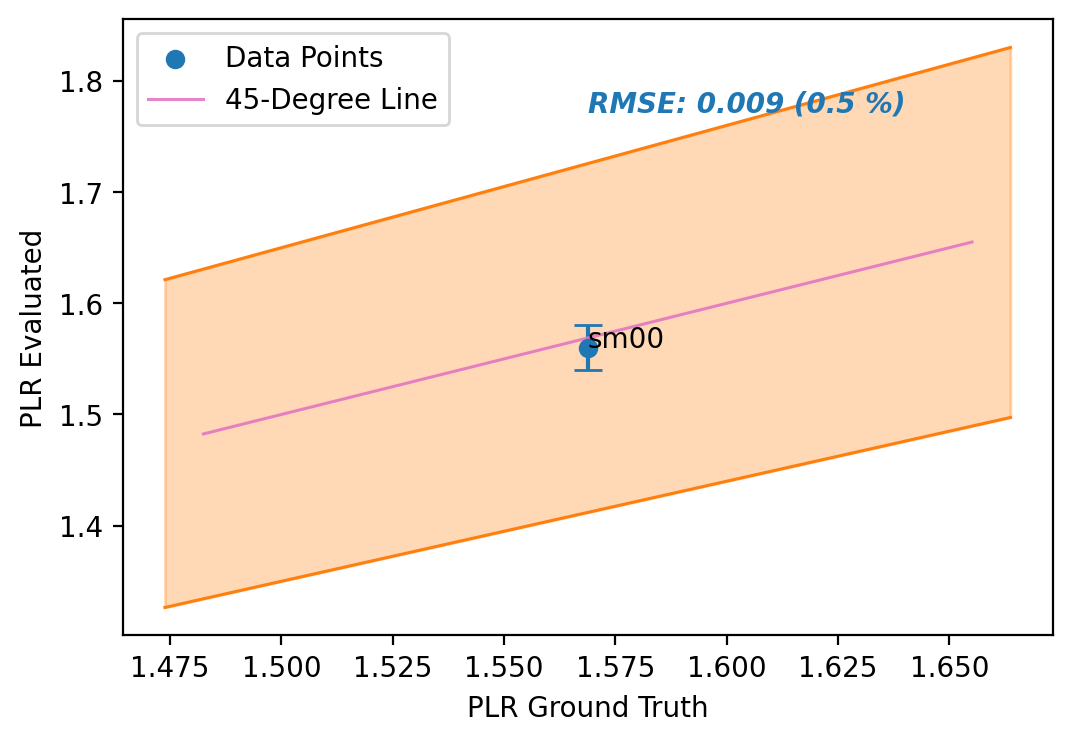

In [11]:
eval = Eval(filepaths, 'BR', model_id, model_dscp, dirc_mets='dl_lost', save_answer=True)
eval.run_hist_method(N=5)
eval.plot()

# A Eval

In [12]:
# Single Radio Example
# dates = data_loader(query_dates=True)

# selected_dates = [s for s in dates if s >= '2023-09-12']
selected_dates = ['2024-03-20']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['A']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

print(len(filepaths))
# pprint(filepaths)

18


./20240403_01430006f4_test/dl_lost/models/A
1/18 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/handover_info_log.csv
1/18 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240403_01430006f4_test/sr_results/dl_lost/A_20240403_0155001_8fbe7/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#01\data\udp_dnlk_loss_latency.csv
./20240403_01430006f4_test/dl_lost/results/A_20240403_0155001_8fbe7.pkl
./20240403_01430006f4_test/dl_lost/figures/A_20240403_0155001_8fbe7.png


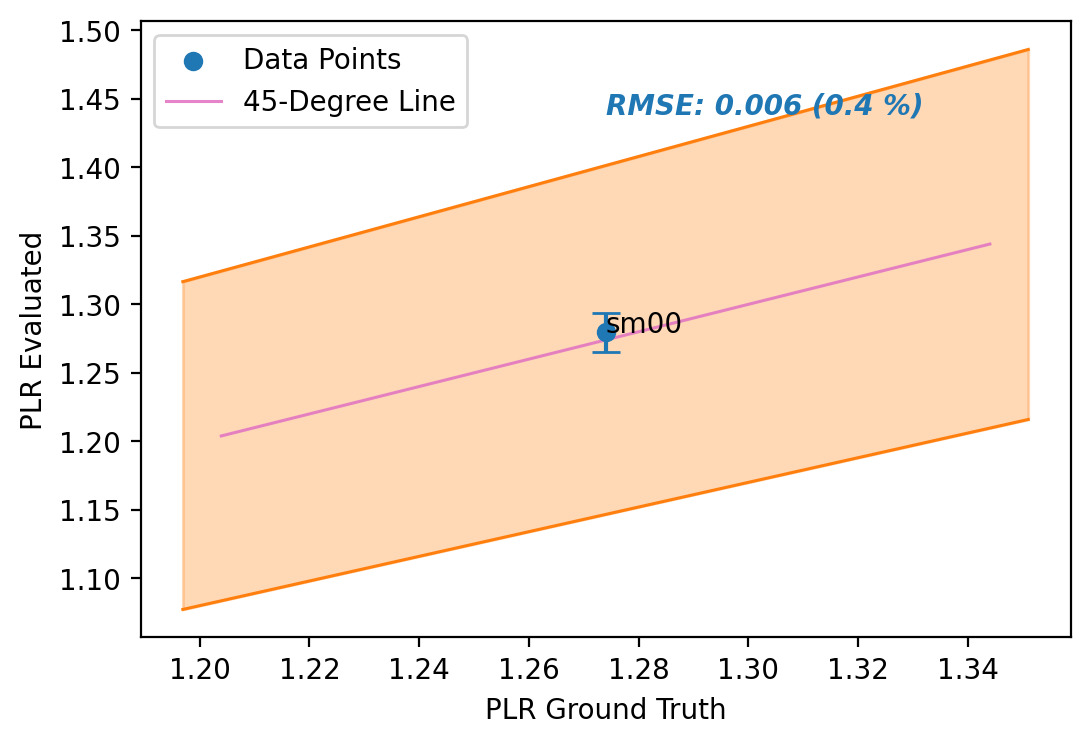

In [13]:
eval = Eval(filepaths, 'A', model_id, model_dscp, dirc_mets='dl_lost', save_answer=True)
eval.run_hist_method(N=5)
eval.plot()

# Show Model ID

In [14]:
print(model_id, model_dscp)

20240403_01430006f4 test
